# Assignment 03 for Neural Fields
This is the task 2 part of the Assignment 03, you will:
- Extend NeRF to render depth, deriving and implementing the volume rendering formula that computes per-ray depth.
- Enhance NeRF with depth supervision, adding a depth loss to the training loop and visualizing the results.

Although the notebook provides skeleton code, the key functionalities must be implemented by the students as detailed below. For better clarity, each code block different from task 1 is accompanied by explanations and guidance.

## Task 2 Depth Rendering and Supervision
In this task you’ll extend your Task 1 NeRF to output per-ray depth maps and use provided ground-truth depth for supervision, implementing the depth-rendering formula, adding a depth loss term, and visualizing the results.

### a. Implement batched_forward function
Write down and annotate for each symbol.
Compositing weights:
$$
w_i = \alpha_i \cdot T_i =
$$
Expected depth:
$$
\text{depth} =
$$
Explain in plain text what happens to the computed depth when a ray does not accumulate any opacity (i.e., it effectively travels to “infinity”), and describe a practical strategy for handling such rays.

### Answer ###
wi: This represents the weight of the i-th sample point along a ray in the final rendered color and depth. It indicates how much this particular sample contributes.

αi: This is the opacity (or alpha) of the i-th sample point. It's typically derived from the density predicted by the NeRF model at that point. A higher opacity means the point is more "solid" and blocks more light.

Ti: This is the transmittance along the ray up to the i-th sample point. It represents the fraction of light that has traveled from the camera to the i-th point without being blocked by any preceding samples.

$$
\text{depth}=∑_i w_i*d_i
$$

wi: As defined above, this is the compositing weight of the i-th sample point.

di: This is the depth value of the i-th sample point along the ray, which is the distance from the camera origin to that point.

In such cases when a ray does not accumulate any opacity:
1. The α_i values for all sampled points along the ray will be close to zero.
2. Consequently, the compositing weights w_i = α_i *⋅T_i will also be close to zero for all samples.
3. As a result, the computed depth, which is a weighted sum of the sample depths, will become unreliable and potentially very large (tending towards "infinity"). This is because the weights associated with even the far-away samples will be negligible, and the formula doesn't have a mechanism to define a finite depth in such scenarios.

A common and practical strategy to handle rays that do not accumulate significant opacity is to assign them a default or maximum depth value.

### b. Implement functions to get depth from NeRF
Complete the helper methods in the modified NeuralRadianceField class. Please fill the blanks in _get_weights (Compute the array of weights), _get_depth (Compute the expected depth), and batched_forward (Obtain the third output rays_depths).

### c. Implement Depth Visualization
Compute percentiles [5, 95] for each depth map. Normalize to [0,1] by clipping to that percentile range. Explain in plain text why we need to convert these values for visualizing the depth.

### Answer ###
Depth values in a scene can vary drastically. For example some may be extremely close (low values), others very far (high values). If we visualize the raw depth directly, a few outlier values (e.g., from distant sky pixels or noisy readings) can skew the whole range, making important depth differences in the foreground invisible. Therefore, converting these values is important for visualizing the depth.

### d. Implement Depth Interface and Loss
Extend the forward pass to produce rendered depths and supervise them with ground truth depth images in the training loop. Please complete the implementation of rendered_depths (Call the forward function of neural_radiance_field) and depth_err (Compute the depth loss using sample_images_at_mc_locs function and Huber loss), by filling in the blanks.

### e. Depth Loss Weighting Experiment
Investigate how the weight on the depth-loss term influences training convergence. Record the results for depth_weight = [0.1, 1.0] in the below table. Explain in plain text why using a larger depth_weight can hinder or improve convergence.
| depth_weight | Convergence (Yes / No) |
|:------------:|:----------------------:|
| 0.1          |       Yes              |
| 1.0          |       No               |

### Answer ###
Smaller weight:
The depth term has a weaker influence, allowing the model to focus more on minimizing color and silhouette losses. This leads to stable convergence, especially early in training, since color/silhouette signals are often stronger and more reliable.

Larger weight:
The depth term dominates the loss. This can improve convergence only if the depth data is accurate and consistent with the color and silhouette information.
However, if depth data is noisy or hard to fit early on, this may hinder convergence, causing the model to overfit depth at the expense of color fidelity or shape consistency.

In [2]:
!pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

  Cloning https://github.com/facebookresearch/pytorch3d.git (to revision stable) to /tmp/pip-req-build-_qgnaa88
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/pytorch3d.git /tmp/pip-req-build-_qgnaa88
  Running command git checkout -q 75ebeeaea0908c5527e7b1e305fbc7681382db47
  Resolved https://github.com/facebookresearch/pytorch3d.git to commit 75ebeeaea0908c5527e7b1e305fbc7681382db47
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pytorch3d: filename=pytorch3d-0.7.8-cp311-cp311-linux_x86_64.whl size=60242973 sha256=fefb361dd344b92c90f935f46eef8940beb06d8d727a8ce67a6cb91569f618d2
  Stored in directory: /tmp/pip-ephem-wheel-cache-92xoji70/wheels/08/90/1b/df18c3e3634f86278e793b87f37ea4c58d0c36731196122518
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31527 sha256=e83275aceaa5c7c25597837

In [4]:
# basic modules
import os
import sys
import time
import json
import glob
import torch
import math
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from IPython import display
from tqdm.notebook import tqdm

# Data structures and functions for rendering
import pytorch3d
from pytorch3d.structures import Volumes
from pytorch3d.transforms import so3_exp_map
from pytorch3d.renderer import (
    FoVPerspectiveCameras,
    NDCMultinomialRaysampler,
    MonteCarloRaysampler,
    EmissionAbsorptionRaymarcher,
    ImplicitRenderer,
    RayBundle,
    ray_bundle_to_ray_points,
)

# obtain the utilized device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    print(
        'Please note that NeRF is a resource-demanding method.'
        + ' Running this notebook on CPU will be extremely slow.'
        + ' We recommend running the example on a GPU'
        + ' with at least 10 GB of memory.'
    )
    device = torch.device("cpu")

# obtain data
from plot_image_grid import image_grid
from generate_cow_renders import generate_cow_renders
# create the default data directory
DATA_DIR = os.path.join("data", "cow_mesh")
print("Data directory: ", DATA_DIR)
target_cameras, target_images, target_silhouettes, target_depths = generate_cow_renders(num_views=40, azimuth_range=180, data_dir=DATA_DIR)
print(f'Generated {len(target_images)} images/silhouettes/depths/cameras.')


# render_size describes the size of both sides of the
# rendered images in pixels. Since an advantage of
# Neural Radiance Fields are high quality renders
# with a significant amount of details, we render
# the implicit function at double the size of
# target images.
render_size = target_images.shape[1] * 2

# Our rendered scene is centered around (0,0,0)
# and is enclosed inside a bounding box
# whose side is roughly equal to 3.0 (world units).
volume_extent_world = 3.0

# 1) Instantiate the raysamplers.

N_pts_per_ray = 64

# Here, NDCMultinomialRaysampler generates a rectangular image
# grid of rays whose coordinates follow the PyTorch3D
# coordinate conventions.
raysampler_grid = NDCMultinomialRaysampler(
    image_height=render_size,
    image_width=render_size,
    n_pts_per_ray=N_pts_per_ray,
    min_depth=0.1,
    max_depth=volume_extent_world,
)

# MonteCarloRaysampler generates a random subset
# of `n_rays_per_image` rays emitted from the image plane.
raysampler_mc = MonteCarloRaysampler(
    min_x = -1.0,
    max_x = 1.0,
    min_y = -1.0,
    max_y = 1.0,
    n_rays_per_image=750,
    n_pts_per_ray=N_pts_per_ray,
    min_depth=0.1,
    max_depth=volume_extent_world,
)

# 2) Instantiate the raymarcher.
# Here, we use the standard EmissionAbsorptionRaymarcher
# which marches along each ray in order to render
# the ray into a single 3D color vector
# and an opacity scalar.
raymarcher = EmissionAbsorptionRaymarcher()

# Finally, instantiate the implicit renders
# for both raysamplers.
renderer_grid = ImplicitRenderer(
    raysampler=raysampler_grid, raymarcher=raymarcher,
)
renderer_mc = ImplicitRenderer(
    raysampler=raysampler_mc, raymarcher=raymarcher,
)

class HarmonicEmbedding(torch.nn.Module):
    def __init__(self, n_harmonic_functions=60, omega0=0.1):
        """
        Given an input tensor `x` of shape [minibatch, ... , dim],
        the harmonic embedding layer converts each feature
        in `x` into a series of harmonic features `embedding`
        as follows:
            embedding[..., i*dim:(i+1)*dim] = [
                sin(x[..., i]),
                sin(2*x[..., i]),
                sin(4*x[..., i]),
                ...
                sin(2**(self.n_harmonic_functions-1) * x[..., i]),
                cos(x[..., i]),
                cos(2*x[..., i]),
                cos(4*x[..., i]),
                ...
                cos(2**(self.n_harmonic_functions-1) * x[..., i])
            ]

        Note that `x` is also premultiplied by `omega0` before
        evaluating the harmonic functions.
        """
        super().__init__()
        self.register_buffer(
            'frequencies',
            omega0 * (2.0 ** torch.arange(n_harmonic_functions)),
        )
    def forward(self, x):
        """
        Args:
            x: tensor of shape [..., dim]
        Returns:
            embedding: a harmonic embedding of `x`
                of shape [..., n_harmonic_functions * dim * 2]
        """
        embed = (x[..., None] * self.frequencies).view(*x.shape[:-1], -1)
        return torch.cat((embed.sin(), embed.cos()), dim=-1)

Data directory:  data/cow_mesh
Generated 40 images/silhouettes/depths/cameras.


## Extend the neural radiance field model to render depth

In this cell, we extend the `NeuralRadianceField` module to make the `forward` function render the depth value of each ray.

We define the `_get_weights` and `_get_depth` functions to help the `forward` function.
We also need to modify the `forward_batched` function.

In [8]:
class NeuralRadianceField(torch.nn.Module):
    def __init__(self, n_harmonic_functions=60, n_hidden_neurons=256):
        super().__init__()
        """
        Args:
            n_harmonic_functions: The number of harmonic functions
                used to form the harmonic embedding of each point.
            n_hidden_neurons: The number of hidden units in the
                fully connected layers of the MLPs of the model.
        """

        # The harmonic embedding layer converts input 3D coordinates
        # to a representation that is more suitable for
        # processing with a deep neural network.
        self.harmonic_embedding = HarmonicEmbedding(n_harmonic_functions)

        # The dimension of the harmonic embedding.
        embedding_dim = n_harmonic_functions * 2 * 3

        # self.mlp is a simple 2-layer multi-layer perceptron
        # which converts the input per-point harmonic embeddings
        # to a latent representation.
        # Not that we use Softplus activations instead of ReLU.
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(embedding_dim, n_hidden_neurons),
            torch.nn.Softplus(beta=10.0),
            torch.nn.Linear(n_hidden_neurons, n_hidden_neurons),
            torch.nn.Softplus(beta=10.0),
        )

        # Given features predicted by self.mlp, self.color_layer
        # is responsible for predicting a 3-D per-point vector
        # that represents the RGB color of the point.
        self.color_layer = torch.nn.Sequential(
            torch.nn.Linear(n_hidden_neurons + embedding_dim, n_hidden_neurons),
            torch.nn.Softplus(beta=10.0),
            torch.nn.Linear(n_hidden_neurons, 3),
            torch.nn.Sigmoid(),
            # To ensure that the colors correctly range between [0-1],
            # the layer is terminated with a sigmoid layer.
        )

        # The density layer converts the features of self.mlp
        # to a 1D density value representing the raw opacity
        # of each point.
        self.density_layer = torch.nn.Sequential(
            torch.nn.Linear(n_hidden_neurons, 1),
            torch.nn.Softplus(beta=10.0),
            # Sofplus activation ensures that the raw opacity
            # is a non-negative number.
        )

        # We set the bias of the density layer to -1.5
        # in order to initialize the opacities of the
        # ray points to values close to 0.
        # This is a crucial detail for ensuring convergence
        # of the model.
        self.density_layer[0].bias.data[0] = -1.5

    def _get_densities(self, features):
        """
        This function takes `features` predicted by `self.mlp`
        and converts them to `raw_densities` with `self.density_layer`.
        `raw_densities` are later mapped to [0-1] range with
        1 - inverse exponential of `raw_densities`.
        """
        raw_densities = self.density_layer(features)
        return 1 - (-raw_densities).exp()

    def _get_colors(self, features, rays_directions):
        """
        This function takes per-point `features` predicted by `self.mlp`
        and evaluates the color model in order to attach to each
        point a 3D vector of its RGB color.

        In order to represent viewpoint dependent effects,
        before evaluating `self.color_layer`, `NeuralRadianceField`
        concatenates to the `features` a harmonic embedding
        of `ray_directions`, which are per-point directions
        of point rays expressed as 3D l2-normalized vectors
        in world coordinates.
        """
        spatial_size = features.shape[:-1]

        # Normalize the ray_directions to unit l2 norm.
        rays_directions_normed = torch.nn.functional.normalize(
            rays_directions, dim=-1
        )

        # Obtain the harmonic embedding of the normalized ray directions.
        rays_embedding = self.harmonic_embedding(
            rays_directions_normed
        )

        # Expand the ray directions tensor so that its spatial size
        # is equal to the size of features.
        rays_embedding_expand = rays_embedding[..., None, :].expand(
            *spatial_size, rays_embedding.shape[-1]
        )

        # Concatenate ray direction embeddings with
        # features and evaluate the color model.
        color_layer_input = torch.cat(
            (features, rays_embedding_expand),
            dim=-1
        )
        return self.color_layer(color_layer_input)

    def forward(
        self,
        ray_bundle: RayBundle,
        **kwargs,
    ):
        """
        The forward function accepts the parametrizations of
        3D points sampled along projection rays. The forward
        pass is responsible for attaching a 3D vector
        and a 1D scalar representing the point's
        RGB color and opacity respectively.

        Args:
            ray_bundle: A RayBundle object containing the following variables:
                origins: A tensor of shape `(minibatch, ..., 3)` denoting the
                    origins of the sampling rays in world coords.
                directions: A tensor of shape `(minibatch, ..., 3)`
                    containing the direction vectors of sampling rays in world coords.
                lengths: A tensor of shape `(minibatch, ..., num_points_per_ray)`
                    containing the lengths at which the rays are sampled.

        Returns:
            rays_densities: A tensor of shape `(minibatch, ..., num_points_per_ray, 1)`
                denoting the opacity of each ray point.
            rays_colors: A tensor of shape `(minibatch, ..., num_points_per_ray, 3)`
                denoting the color of each ray point.
            rays_depths: A tensor of shape `(minibatch, ..., 1)`
                denoting the aggregated depth for each ray (i.e. the expected distance along that ray).
        """
        # We first convert the ray parametrizations to world
        # coordinates with `ray_bundle_to_ray_points`.
        rays_points_world = ray_bundle_to_ray_points(ray_bundle)
        # rays_points_world.shape = [minibatch x ... x 3]

        # For each 3D world coordinate, we obtain its harmonic embedding.
        embeds = self.harmonic_embedding(
            rays_points_world
        )
        # embeds.shape = [minibatch x ... x self.n_harmonic_functions*6]

        # self.mlp maps each harmonic embedding to a latent feature space.
        features = self.mlp(embeds)
        # features.shape = [minibatch x ... x n_hidden_neurons]

        # Finally, given the per-point features,
        # execute the density and color branches.

        rays_densities = self._get_densities(features)
        # rays_densities.shape = [minibatch x ... x 1]

        rays_colors = self._get_colors(features, ray_bundle.directions)
        # rays_colors.shape = [minibatch x ... x 3

        # Compute depth per ray
        alphas_s = rays_densities[..., 0]  # [..., n_pts]
        lengths = ray_bundle.lengths  # [..., n_pts]
        rays_depths = self._get_depth(alphas_s, lengths)  # [...]

        return rays_densities, rays_colors, rays_depths

    # TODO: b. Implement functions to get depth from NeRF
    def _get_weights(self, alphas, lengths):
        """
        Compute volume‐rendering weights for each sample along a ray.

        Each sample’s contribution weight w_i is defined as:
            w_i = α_i * T_i,
        where
            α_i      = opacity at sample i,
            T_i = ∏_{j < i}(1 − α_j) is the accumulated transmittance
                    up to—but not including—sample i.

        Args:
            alphas (Tensor): shape [..., n_pts]
                The per‐sample opacities (in [0,1]) along each ray.
            lengths (Tensor): shape [..., n_pts]
                The distance (t_i) from the ray origin to each sample.

        Returns:
            weights (Tensor): shape [..., n_pts]
                The composite weights w_i for volume rendering,
                ready to be used in color and depth integration.
        """
        deltas = lengths[..., 1:] - lengths[..., :-1]
        delta_inf = 1e10 * torch.ones_like(deltas[..., :1])
        deltas = torch.cat([deltas, delta_inf], dim=-1)

        alphas_shifted = torch.cat([
            torch.ones_like(alphas[..., :1]),
            (1. - alphas + 1e-10)[..., :-1]
        ], dim=-1)
        trans = torch.cumprod(alphas_shifted, dim=-1)

        return alphas * trans

    def _get_depth(self, alphas, lengths):
        """
        Compute the expected depth along each ray via weighted sum.

        The per‐ray depth is the sum of each sample’s distance
        weighted by its volume‐rendering weight:
            depth = ∑_i w_i * t_i

        Args:
            alphas (Tensor): shape [..., n_pts]
                The per‐sample opacities along each ray.
            lengths (Tensor): shape [..., n_pts]
                The distances t_i from the ray origin to each sample.

        Returns:
            depth (Tensor): shape [...]  or [..., 1]
                The expected depth for each ray, i.e. one scalar per ray
                obtained by summing w_i * t_i over all samples.
        """
        weights = self._get_weights(alphas, lengths)
        depth = torch.sum(weights * lengths, dim=-1, keepdim=True)
        return depth


    def batched_forward(
        self,
        ray_bundle: RayBundle,
        n_batches: int = 16,
        **kwargs,
    ):
        """
        This function is used to allow for memory efficient processing
        of input rays. The input rays are first split to `n_batches`
        chunks and passed through the `self.forward` function one at a time
        in a for loop. Combined with disabling PyTorch gradient caching
        (`torch.no_grad()`), this allows for rendering large batches
        of rays that do not all fit into GPU memory in a single forward pass.
        In our case, batched_forward is used to export a fully-sized render
        of the radiance field for visualization purposes.

        Args:
            ray_bundle: A RayBundle object containing the following variables:
                origins: A tensor of shape `(minibatch, ..., 3)` denoting the
                    origins of the sampling rays in world coords.
                directions: A tensor of shape `(minibatch, ..., 3)`
                    containing the direction vectors of sampling rays in world coords.
                lengths: A tensor of shape `(minibatch, ..., num_points_per_ray)`
                    containing the lengths at which the rays are sampled.
            n_batches: Specifies the number of batches the input rays are split into.
                The larger the number of batches, the smaller the memory footprint
                and the lower the processing speed.

        Returns:
            rays_densities: A tensor of shape `(minibatch, ..., num_points_per_ray, 1)`
                denoting the opacity of each ray point.
            rays_colors: A tensor of shape `(minibatch, ..., num_points_per_ray, 3)`
                denoting the color of each ray point.
            rays_depths: A tensor of shape `(minibatch, ..., 1)`
                denoting the aggregated depth for each ray (i.e. the expected distance along that ray).
        """

        # Parse out shapes needed for tensor reshaping in this function.
        n_pts_per_ray = ray_bundle.lengths.shape[-1]
        spatial_size = [*ray_bundle.origins.shape[:-1], n_pts_per_ray]

        # Split the rays to `n_batches` batches.
        tot_samples = ray_bundle.origins.shape[:-1].numel()
        batches = torch.chunk(torch.arange(tot_samples), n_batches)

        # For each batch, execute the standard forward pass.
        batch_outputs = []
        for batch in batches:
            # Reshape for batch indexing
            idx = batch.view(-1)
            ray_bundle_batch = RayBundle(
                origins=ray_bundle.origins.view(-1, 3)[idx],
                directions=ray_bundle.directions.view(-1, 3)[idx],
                lengths=ray_bundle.lengths.view(-1, n_pts_per_ray)[idx],
                xys=ray_bundle.xys.view(-1, 2)[idx],
            )
            with torch.no_grad():
                out = self.forward(ray_bundle_batch)
            batch_outputs.append(out)

        # Concatenate the per-batch rays_densities, rays_colors, and rays_depths
        # and reshape according to the sizes of the inputs.
        rays_densities = torch.cat([x[0] for x in batch_outputs], dim=0).view(*spatial_size, 1)

        rays_colors = torch.cat([x[1] for x in batch_outputs], dim=0).view(*spatial_size, 3)

        rays_depths = torch.cat([x[2] for x in batch_outputs], dim=0).view(*spatial_size[:-1], 1)

        return rays_densities, rays_colors, rays_depths

## Helper Wrappers for volumetric_function in ImplicitRenderer

PyTorch3D’s ImplicitRenderer expects a volume function that returns exactly two tensors (densities and features), but our NeRF model’s forward pass produces three outputs (densities, colors, and depths). These helper wrappers `nerf_rgb_only` and `nerf_rgb_only_batched` call the full model internally, then select and return only the first two outputs so that they conform to the renderer’s required (densities, features) signature.

In [9]:
def nerf_rgb_only(ray_bundle: RayBundle, **kwargs):
    a, c, _ = neural_radiance_field(ray_bundle, **kwargs)
    return a, c

def nerf_rgb_only_batched(ray_bundle: RayBundle, **kwargs):
    a, c, _ = neural_radiance_field.batched_forward(ray_bundle)
    return a, c

def huber(x, y, scaling=0.1):
    """
    A helper function for evaluating the smooth L1 (huber) loss
    between the rendered silhouettes and colors.
    """
    diff_sq = (x - y) ** 2
    loss = ((1 + diff_sq / (scaling**2)).clamp(1e-4).sqrt() - 1) * float(scaling)
    return loss

def sample_images_at_mc_locs(target_images, sampled_rays_xy):
    """
    Given a set of Monte Carlo pixel locations `sampled_rays_xy`,
    this method samples the tensor `target_images` at the
    respective 2D locations.

    This function is used in order to extract the colors from
    ground truth images that correspond to the colors
    rendered using `MonteCarloRaysampler`.
    """
    ba = target_images.shape[0]
    dim = target_images.shape[-1]
    spatial_size = sampled_rays_xy.shape[1:-1]
    # In order to sample target_images, we utilize
    # the grid_sample function which implements a
    # bilinear image sampler.
    # Note that we have to invert the sign of the
    # sampled ray positions to convert the NDC xy locations
    # of the MonteCarloRaysampler to the coordinate
    # convention of grid_sample.
    images_sampled = torch.nn.functional.grid_sample(
        target_images.permute(0, 3, 1, 2),
        -sampled_rays_xy.view(ba, -1, 1, 2),  # note the sign inversion
        align_corners=True
    )
    return images_sampled.permute(0, 2, 3, 1).view(
        ba, *spatial_size, dim
    )

def show_full_render(
    neural_radiance_field, camera,
    target_image, target_silhouette, target_depth,
    loss_history_color, loss_history_sil, loss_history_depth
):
    """
    This is a helper function for visualizing the
    intermediate results of the learning.

    Since the `NeuralRadianceField` suffers from
    a large memory footprint, which does not let us
    render the full image grid in a single forward pass,
    we utilize the `NeuralRadianceField.batched_forward`
    function in combination with disabling the gradient caching.
    This chunks the set of emitted rays to batches and
    evaluates the implicit function on one batch at a time
    to prevent GPU memory overflow.
    """

    # Prevent gradient caching.
    with torch.no_grad():
        # Render using the grid renderer and the
        # batched_forward function of neural_radiance_field.
        rendered_image_silhouette, sampled_rays = renderer_grid(
            cameras=camera,
            volumetric_function=nerf_rgb_only_batched
        )
        # Split the rendering result to a silhouette render
        # and the image render.
        rendered_image, rendered_silhouette = (
            rendered_image_silhouette[0].split([3, 1], dim=-1)
        )
        _, _, rendered_depth = neural_radiance_field.batched_forward(sampled_rays)

    # TODO: c. Implement Depth Visualization
    # Note: normalize the depth values using its 5th–95th percentile to a [0,1] range
    d = rendered_depth.detach().cpu().numpy()[0]
    d_min, d_max = np.percentile(d, [5, 95])
    d_vis = np.clip((d - d_min) / (d_max - d_min + 1e-8), 0.0, 1.0)
    td = target_depth.cpu().numpy()
    td_min, td_max = np.percentile(td, [5, 95])
    td_vis = np.clip((td - td_min) / (td_max - td_min + 1e-8), 0.0, 1.0)

    # Generate plots.
    fig, ax = plt.subplots(3, 3, figsize=(15, 10))
    ax = ax.ravel()
    clamp_and_detach = lambda x: x.clamp(0.0, 1.0).cpu().detach().numpy()

    ax[0].plot(list(range(len(loss_history_color))), loss_history_color, linewidth=1)
    ax[1].imshow(clamp_and_detach(rendered_image))
    ax[2].imshow(clamp_and_detach(target_image))

    ax[3].plot(list(range(len(loss_history_sil))), loss_history_sil, linewidth=1)
    ax[4].imshow(clamp_and_detach(rendered_silhouette[..., 0]))
    ax[5].imshow(clamp_and_detach(target_silhouette))

    ax[6].plot(list(range(len(loss_history_depth))), loss_history_depth, linewidth=1)
    ax[7].imshow(d_vis)
    ax[8].imshow(td_vis)

    for ax_, title_ in zip(
        ax,
        (
            "loss color", "rendered image", "target image",
            "loss silhouette", "rendered silhouette", "target silhouette",
            "loss depth", "rendered depth", "target depth",
        )
    ):
        if not title_.startswith('loss'):
            ax_.grid("off")
            ax_.axis("off")
        ax_.set_title(title_)
    fig.canvas.draw(); fig.show()
    display.clear_output(wait=True)
    display.display(fig)
    return fig


## Fit the radiance field with Depth Loss

In this step, we perform differentiable volume rendering to fit the NeRF model and incorporate an additional depth‐based loss term into the training objective.

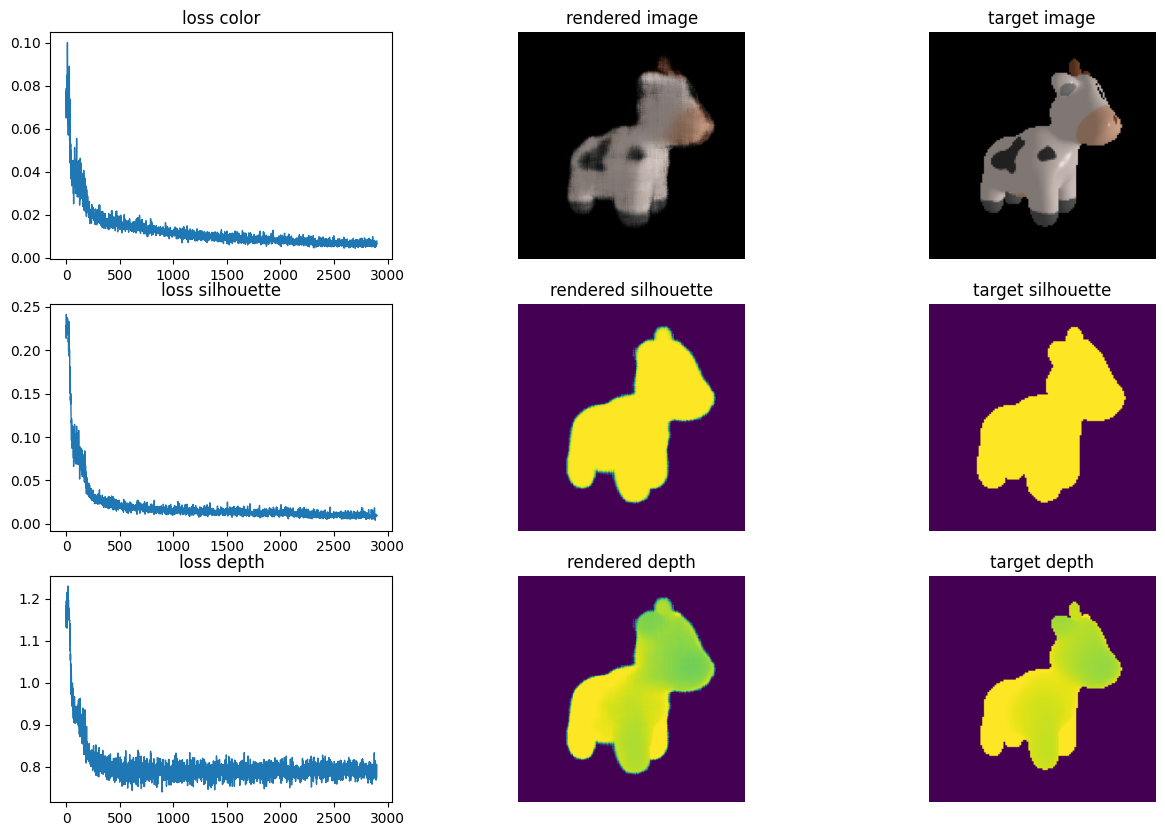

Iteration 02910: loss color = 6.26e-03 loss silhouette = 1.06e-02 loss depth = 7.80e-01
Iteration 02920: loss color = 8.80e-03 loss silhouette = 6.52e-03 loss depth = 7.83e-01
Iteration 02930: loss color = 7.60e-03 loss silhouette = 1.02e-02 loss depth = 8.05e-01
Iteration 02940: loss color = 6.93e-03 loss silhouette = 8.28e-03 loss depth = 7.77e-01
Iteration 02950: loss color = 5.42e-03 loss silhouette = 7.76e-03 loss depth = 8.07e-01
Iteration 02960: loss color = 7.07e-03 loss silhouette = 5.74e-03 loss depth = 7.65e-01
Iteration 02970: loss color = 5.98e-03 loss silhouette = 1.10e-02 loss depth = 7.93e-01
Iteration 02980: loss color = 4.79e-03 loss silhouette = 5.83e-03 loss depth = 7.89e-01
Iteration 02990: loss color = 5.50e-03 loss silhouette = 5.71e-03 loss depth = 7.84e-01


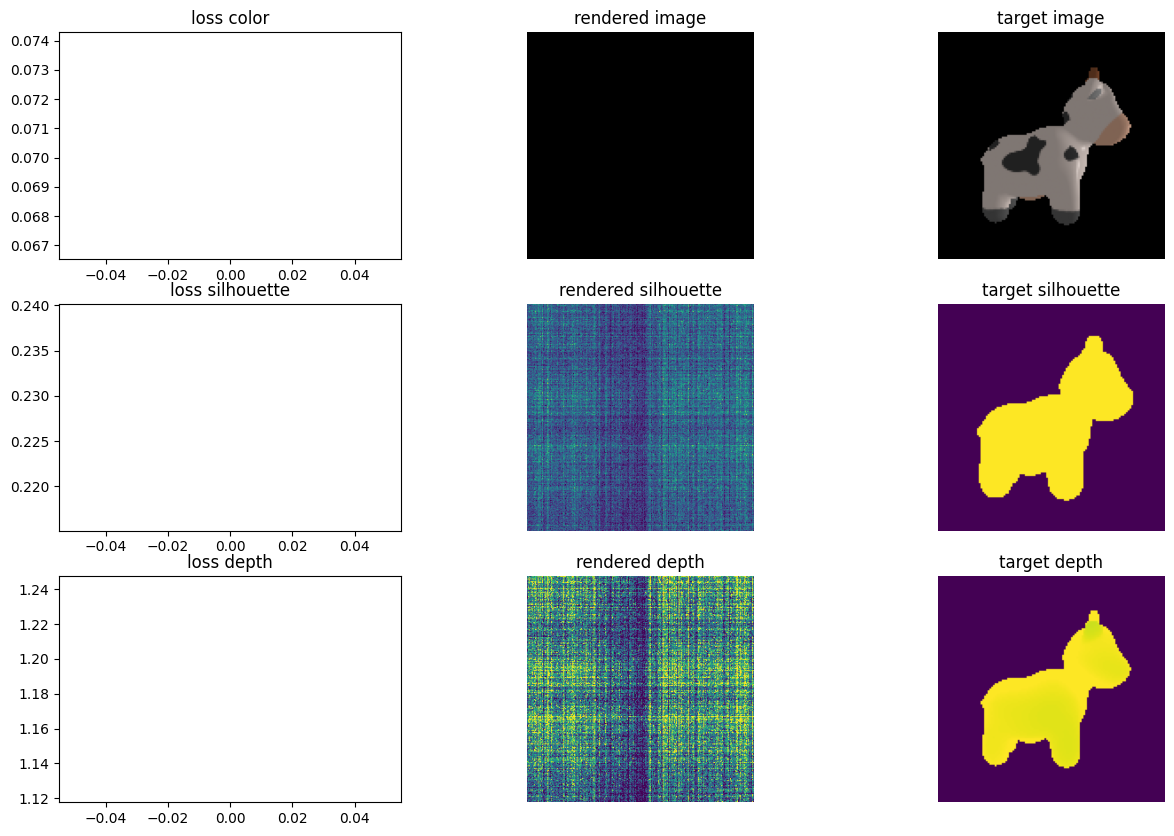

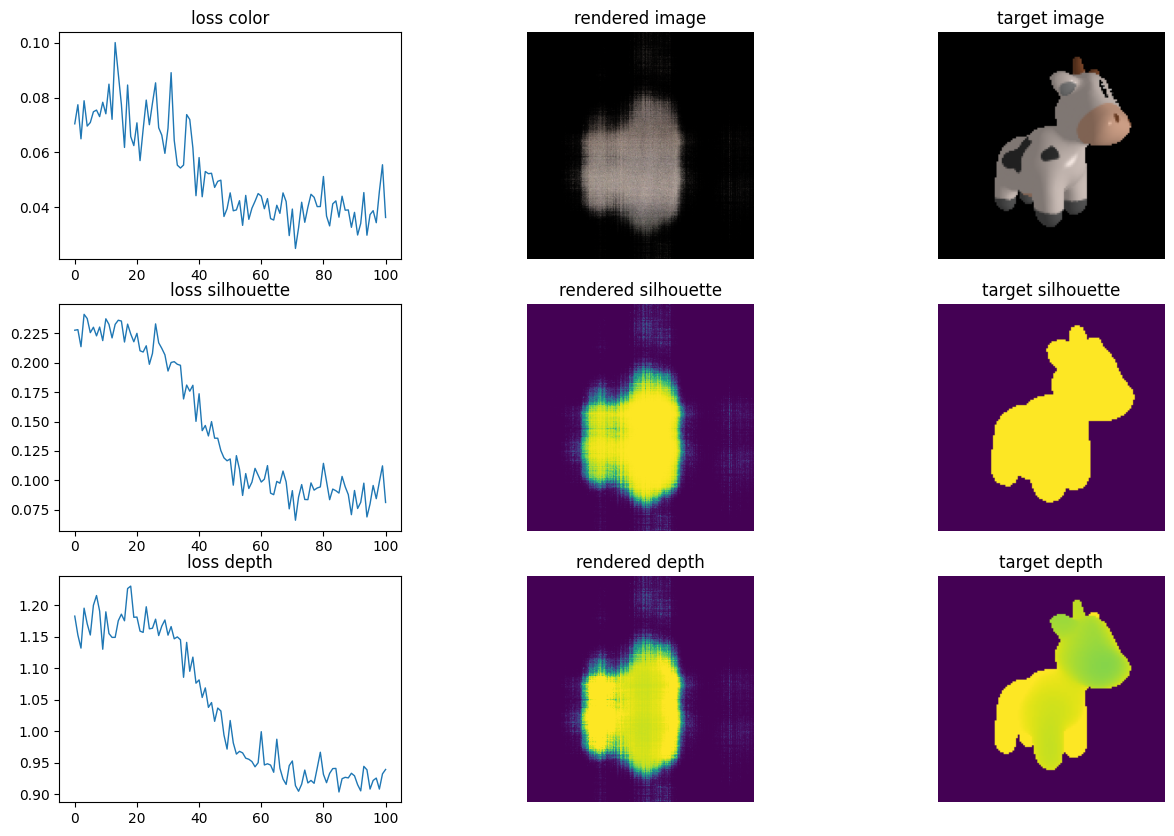

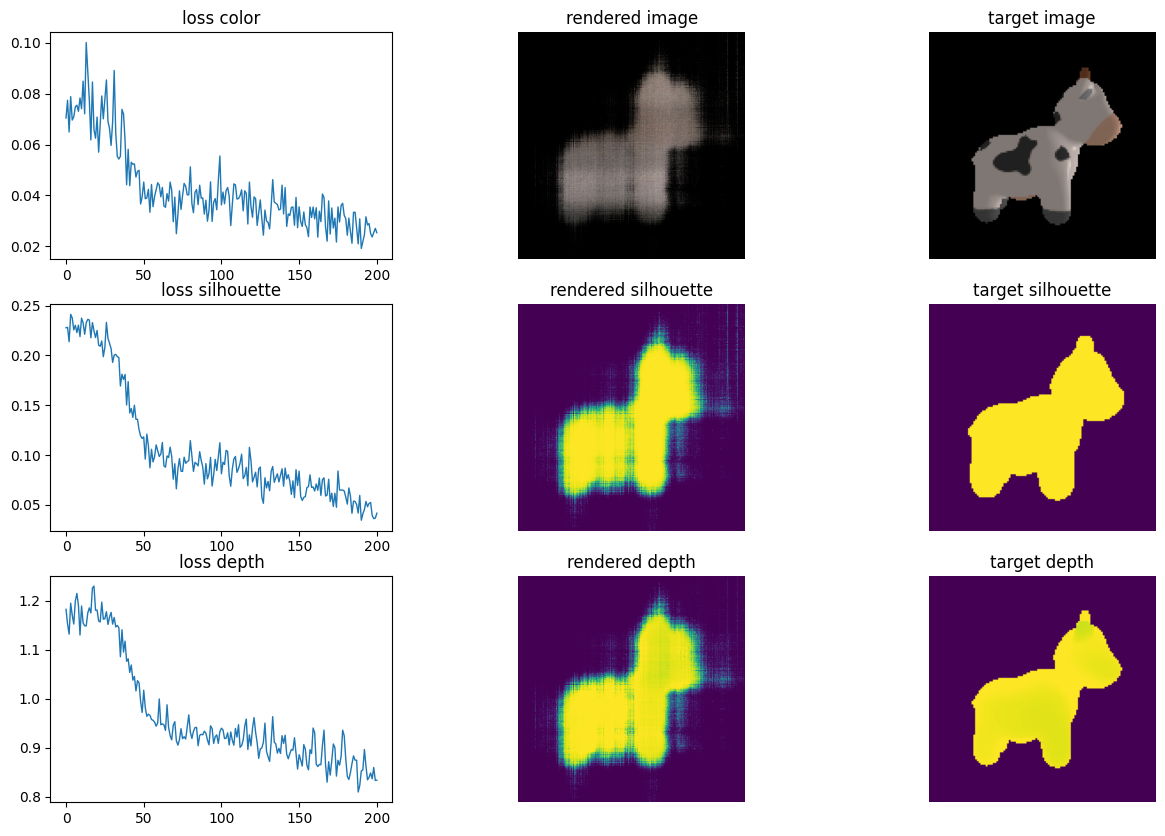

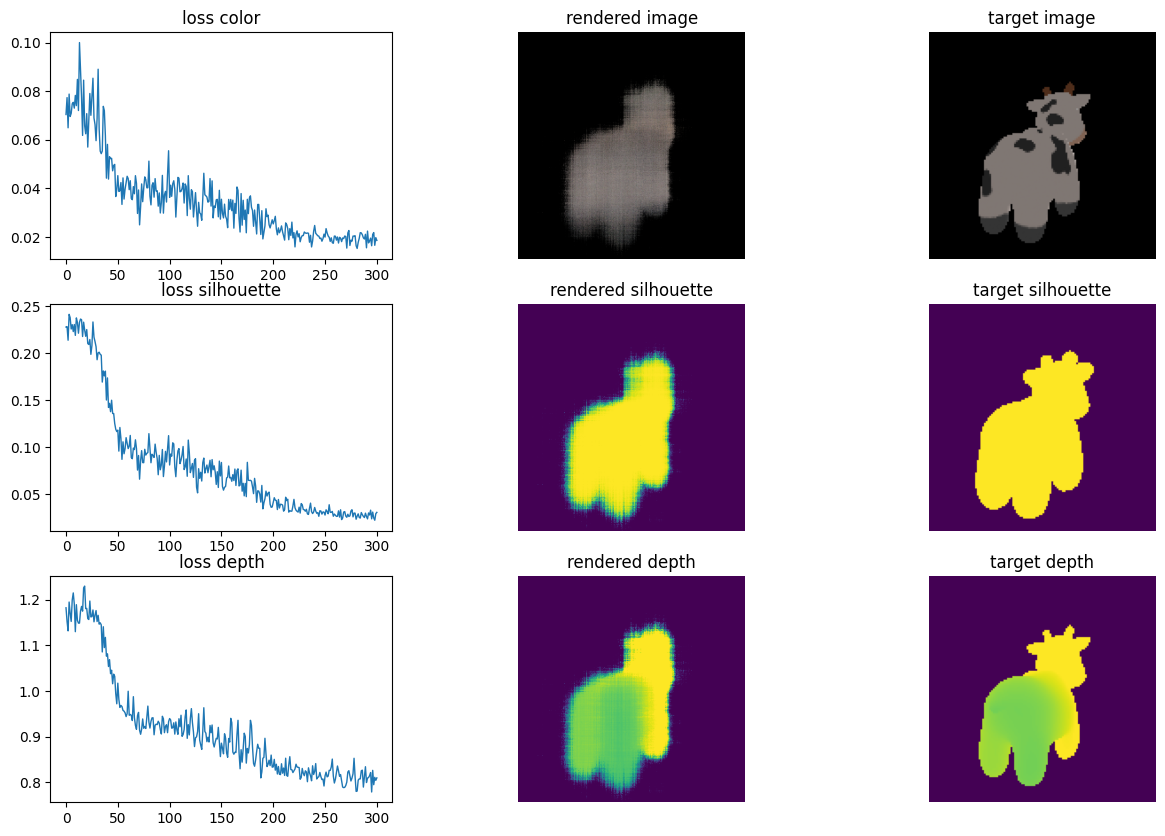

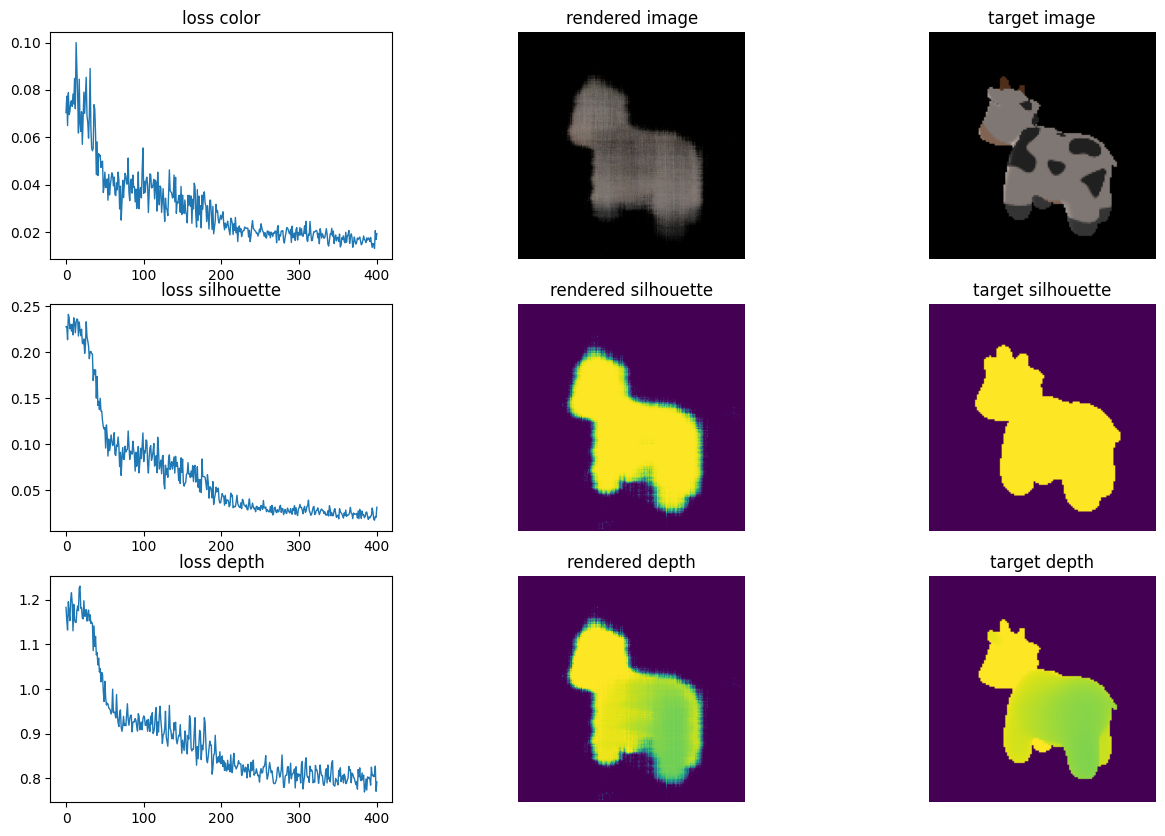

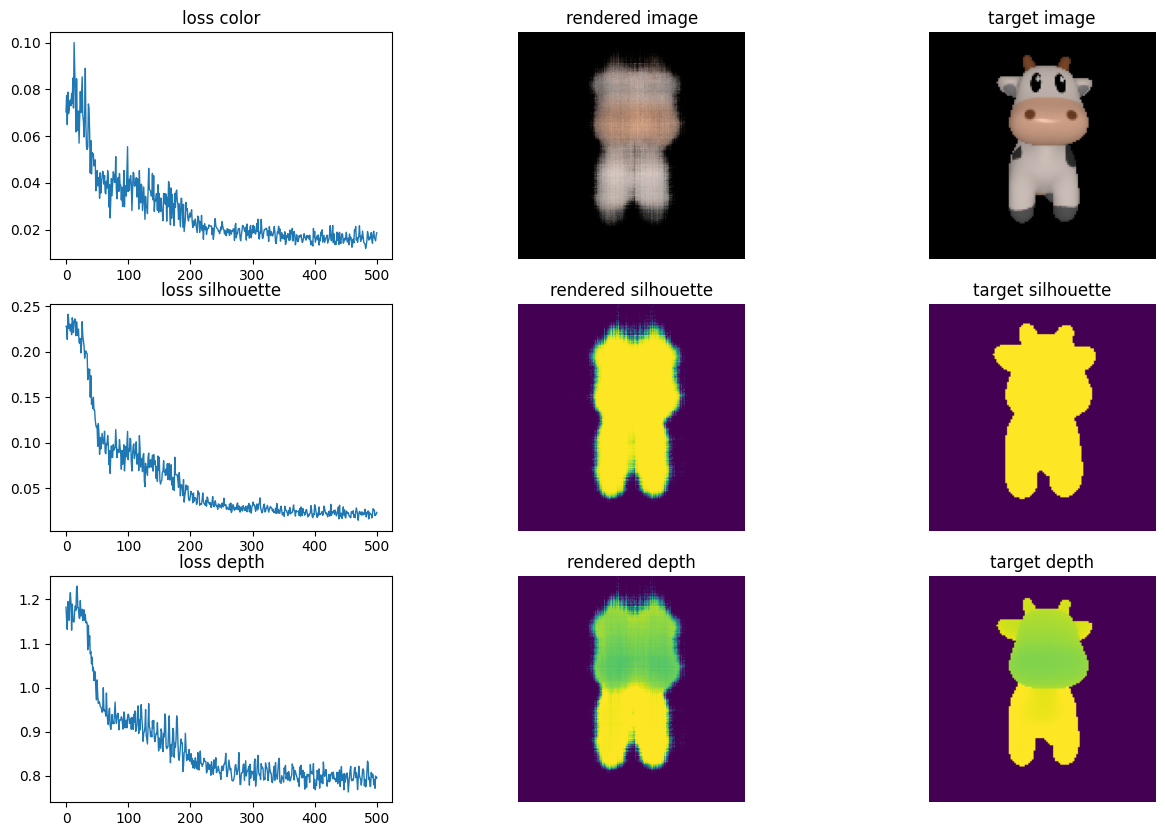

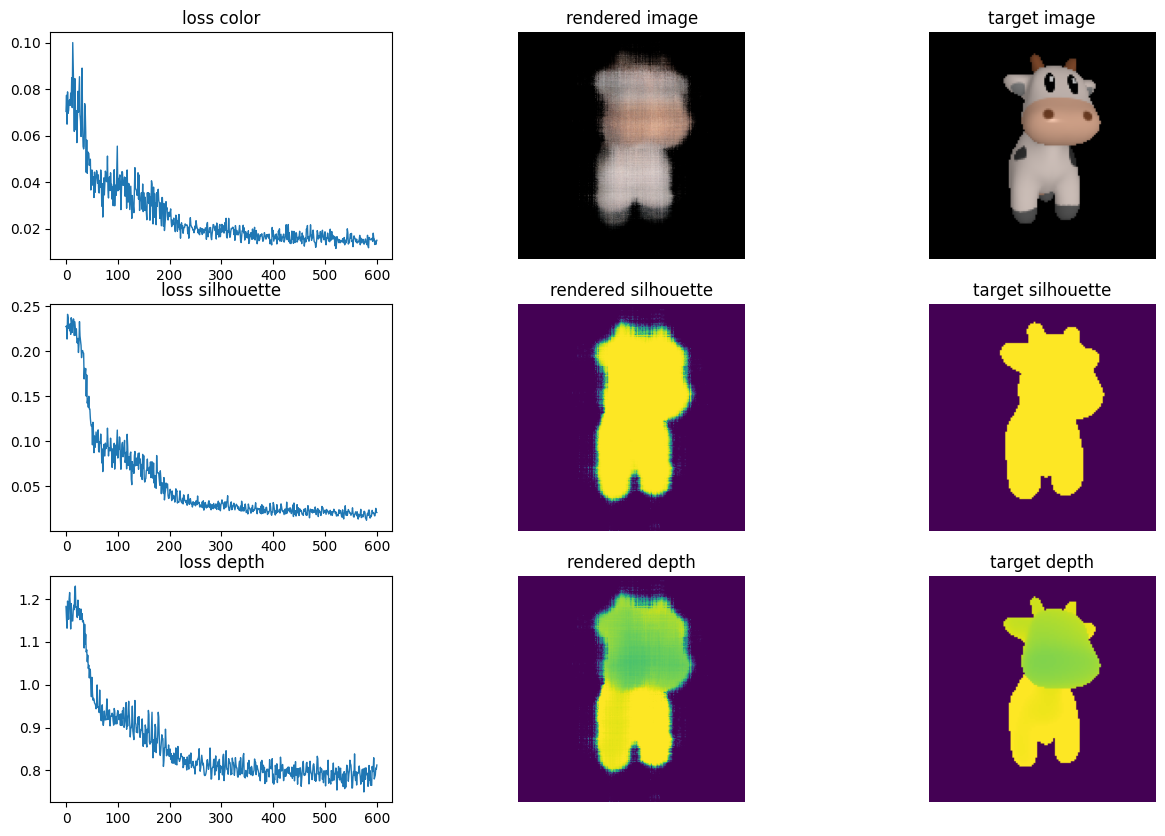

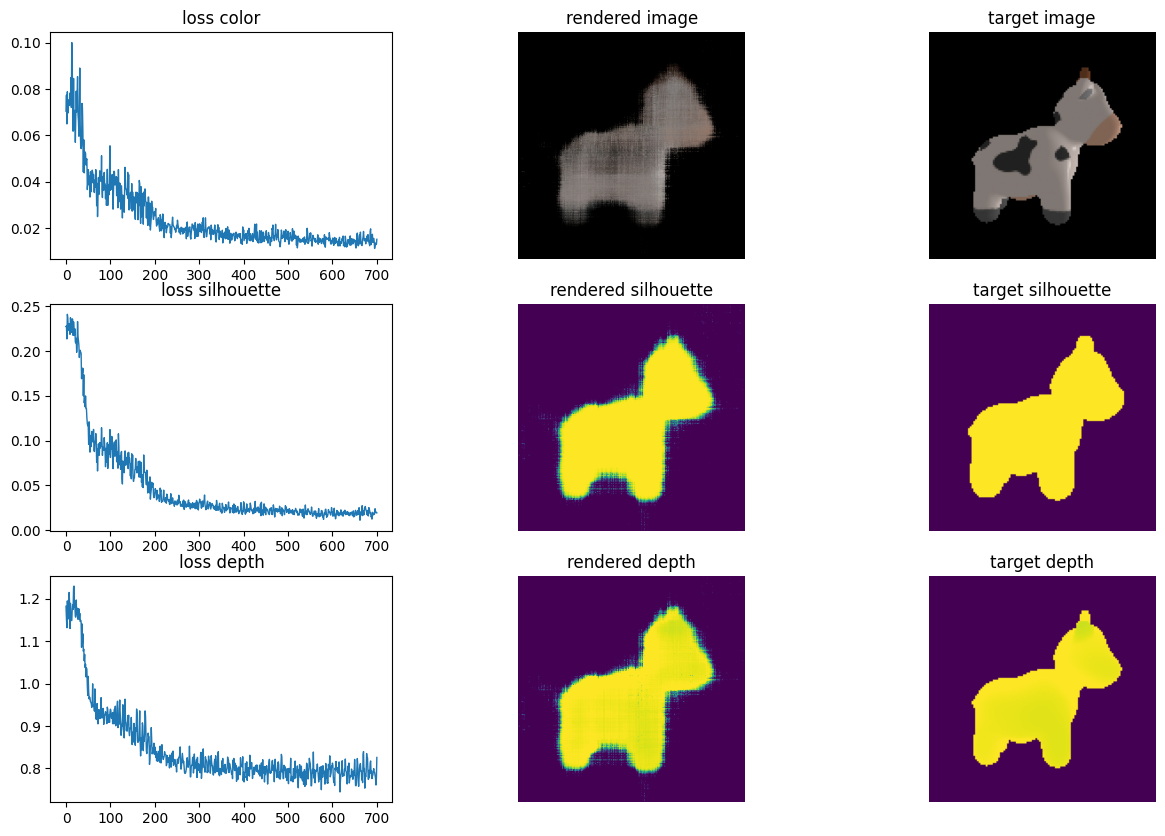

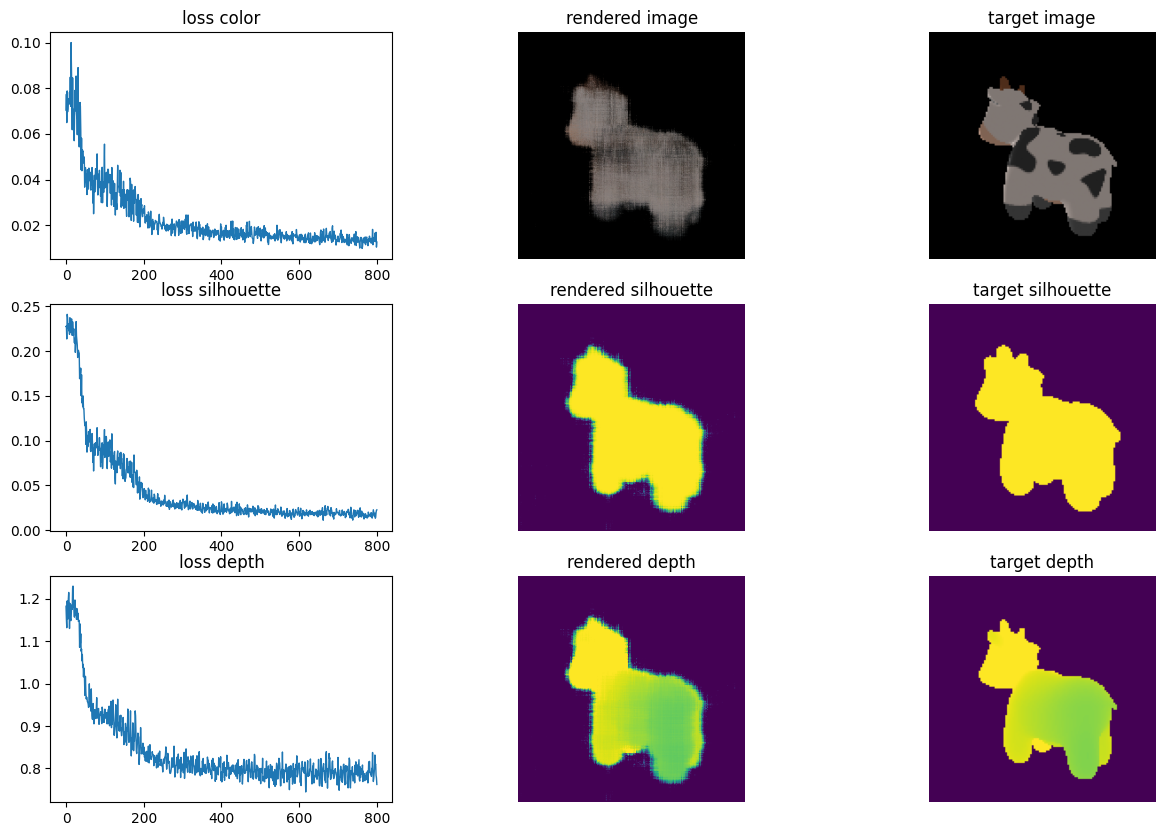

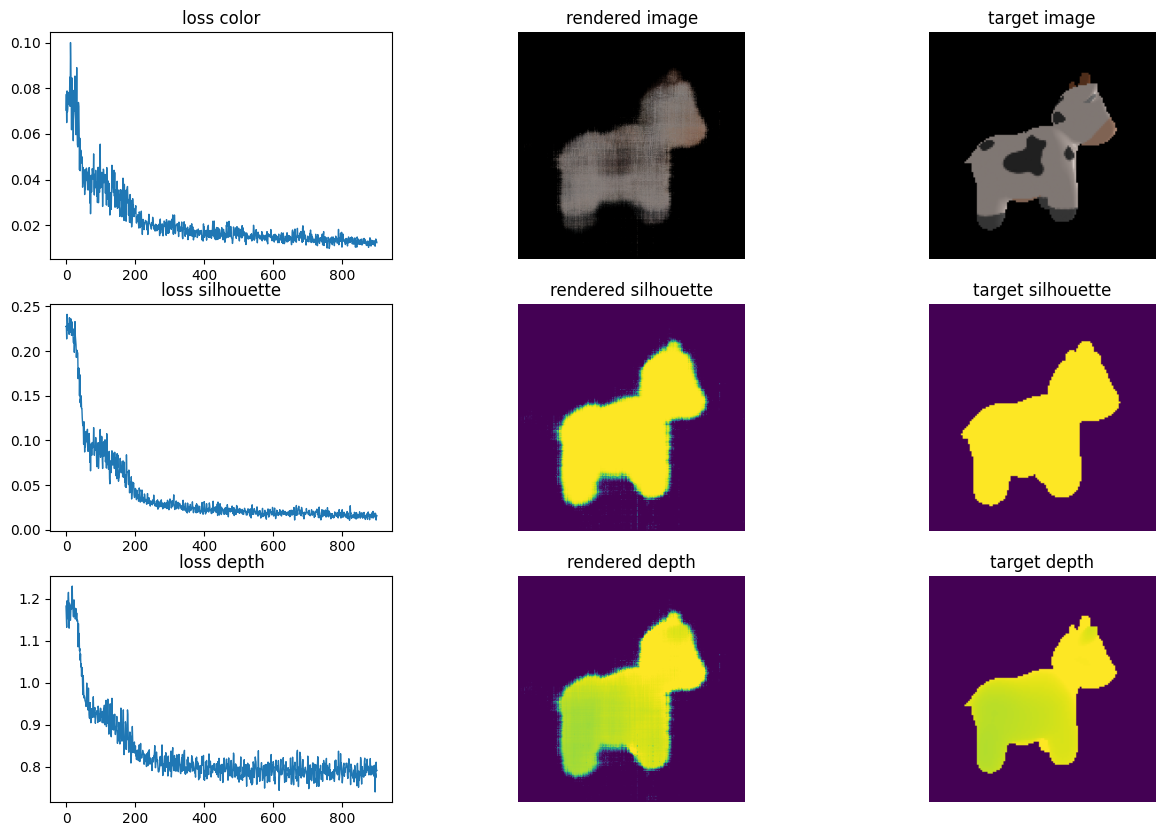

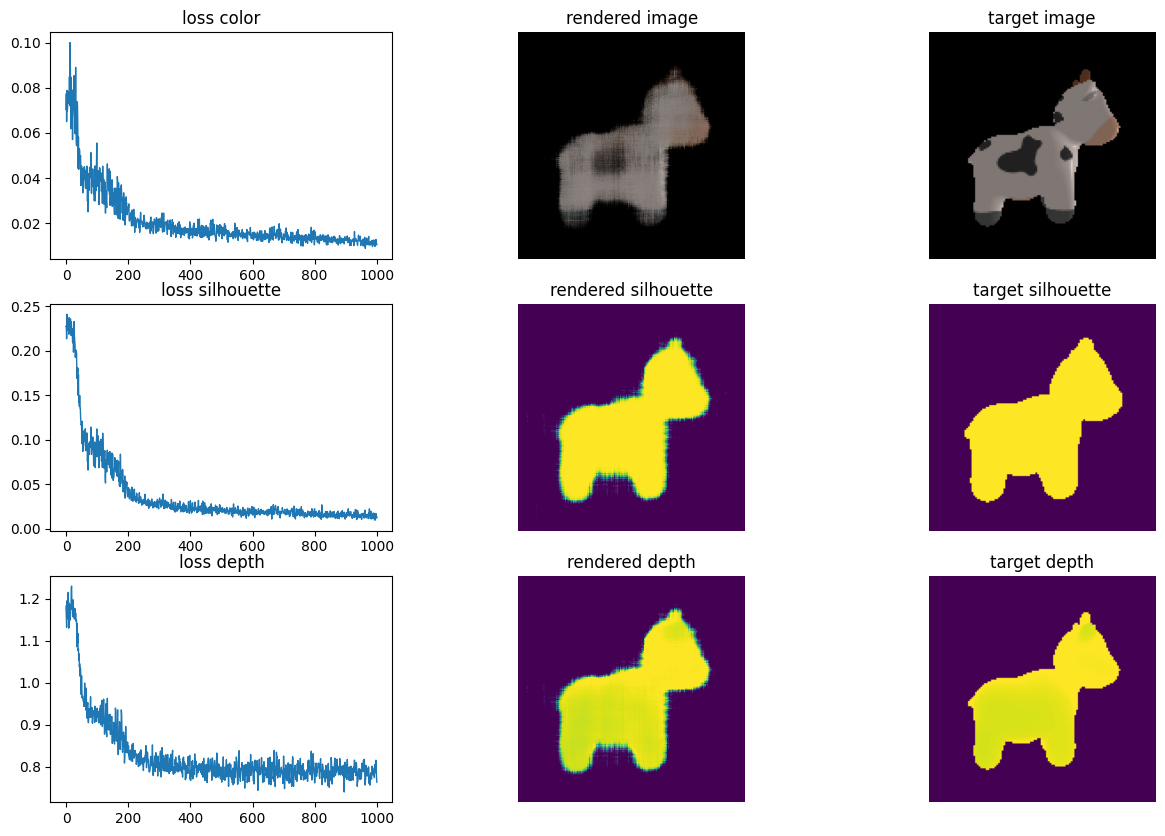

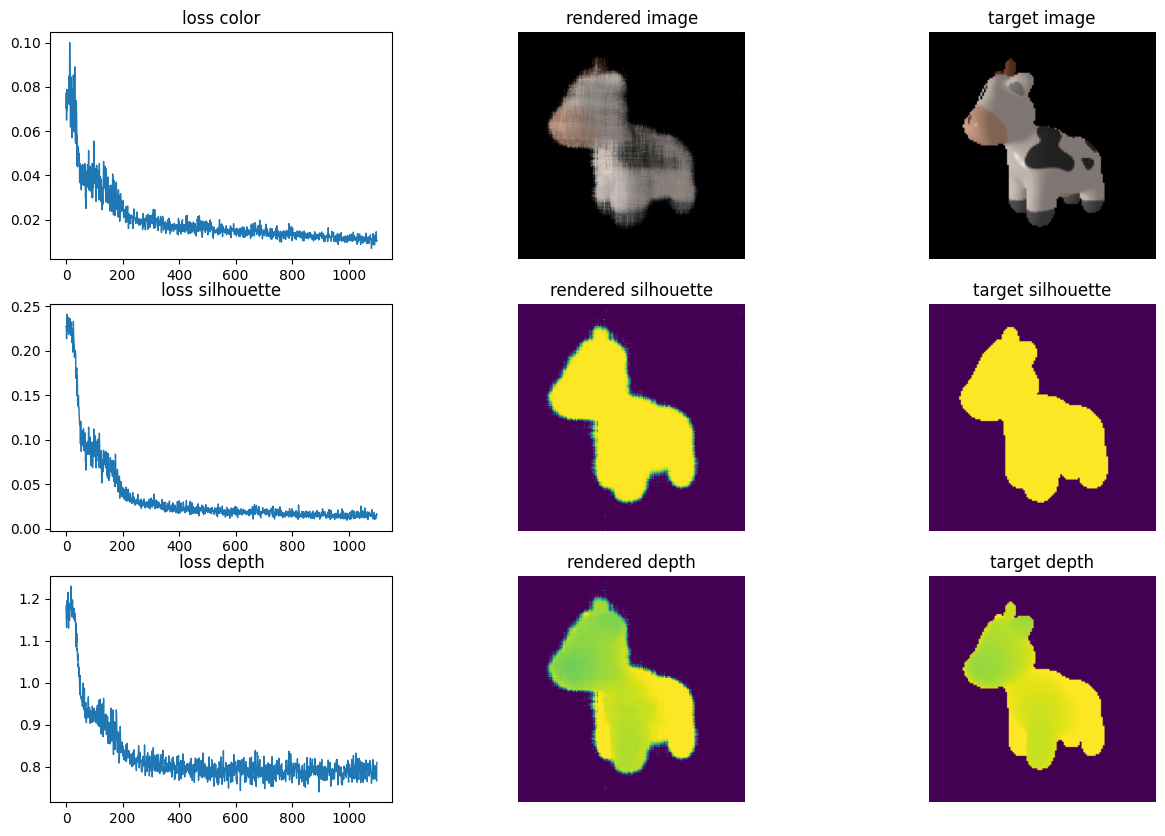

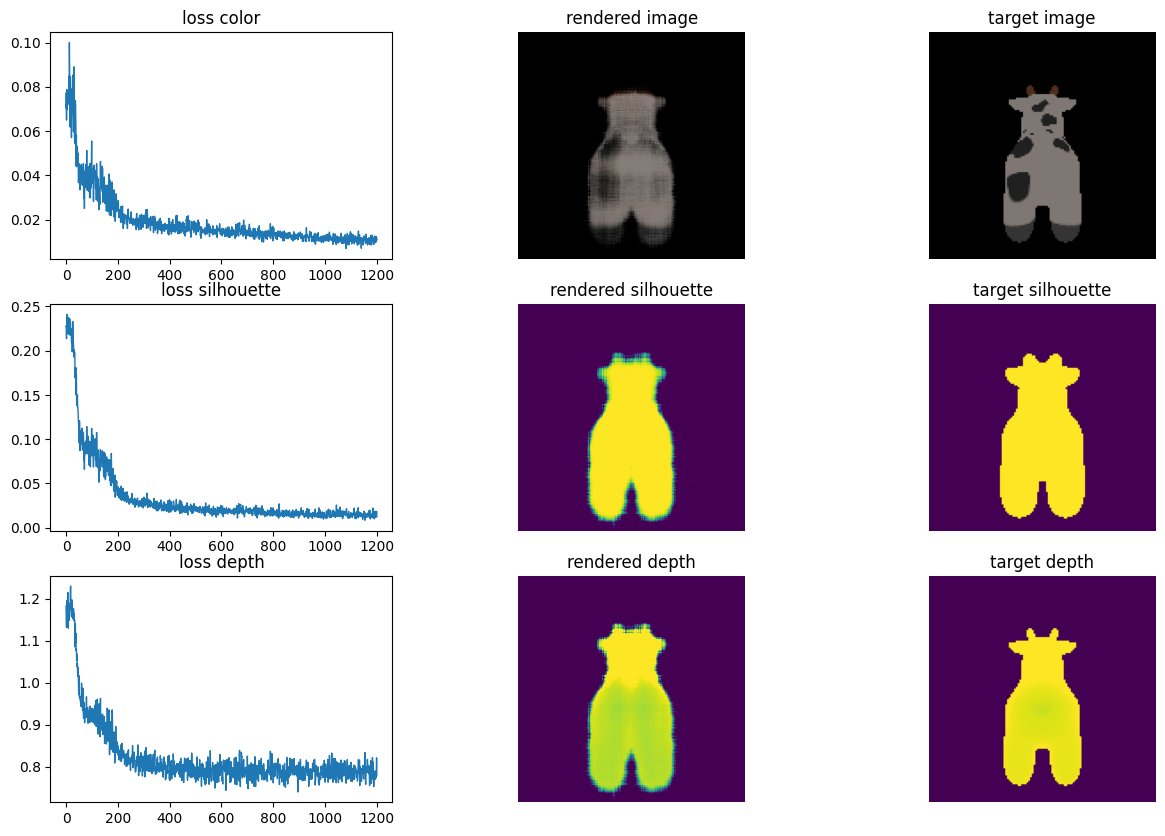

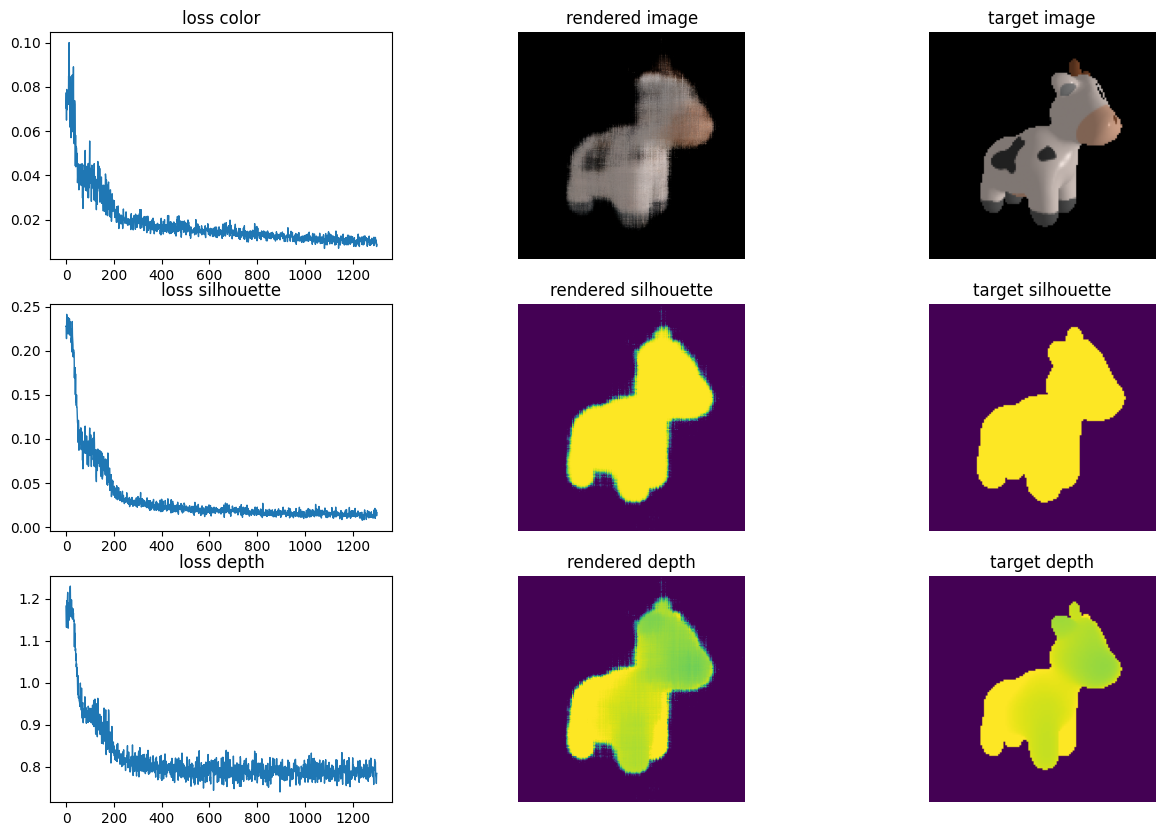

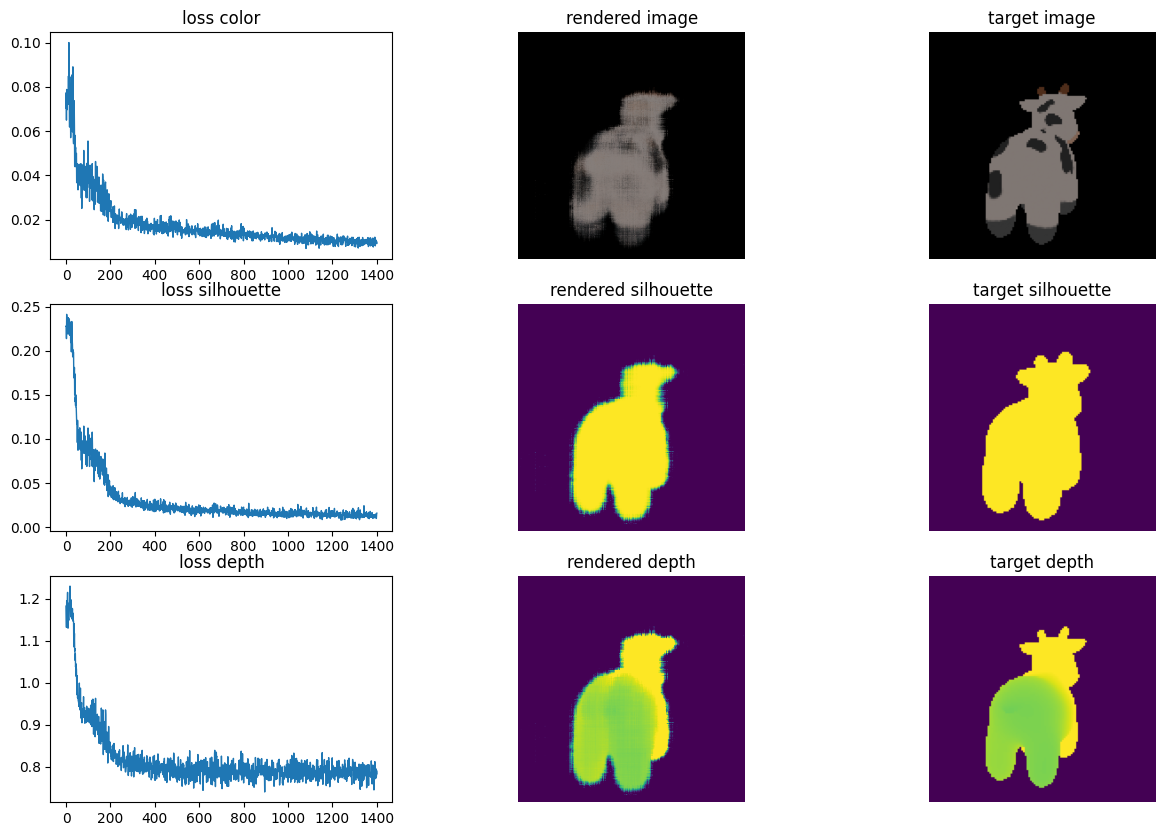

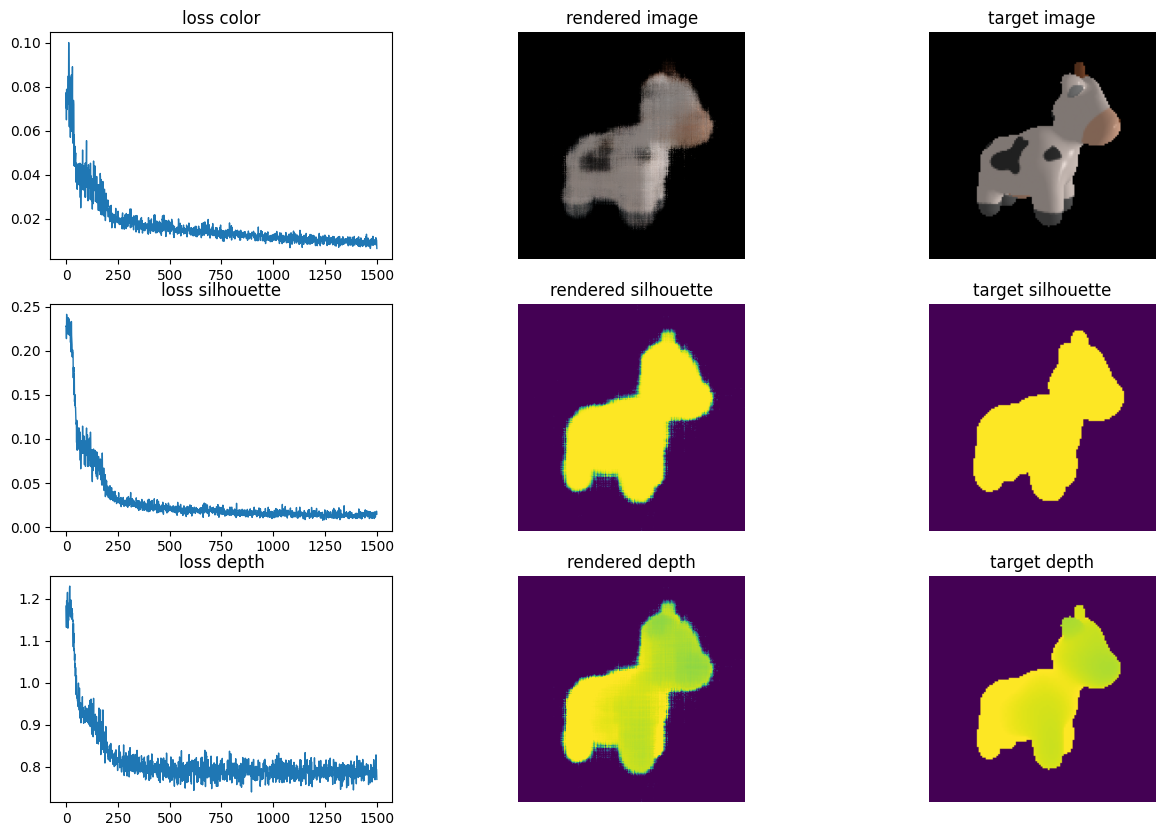

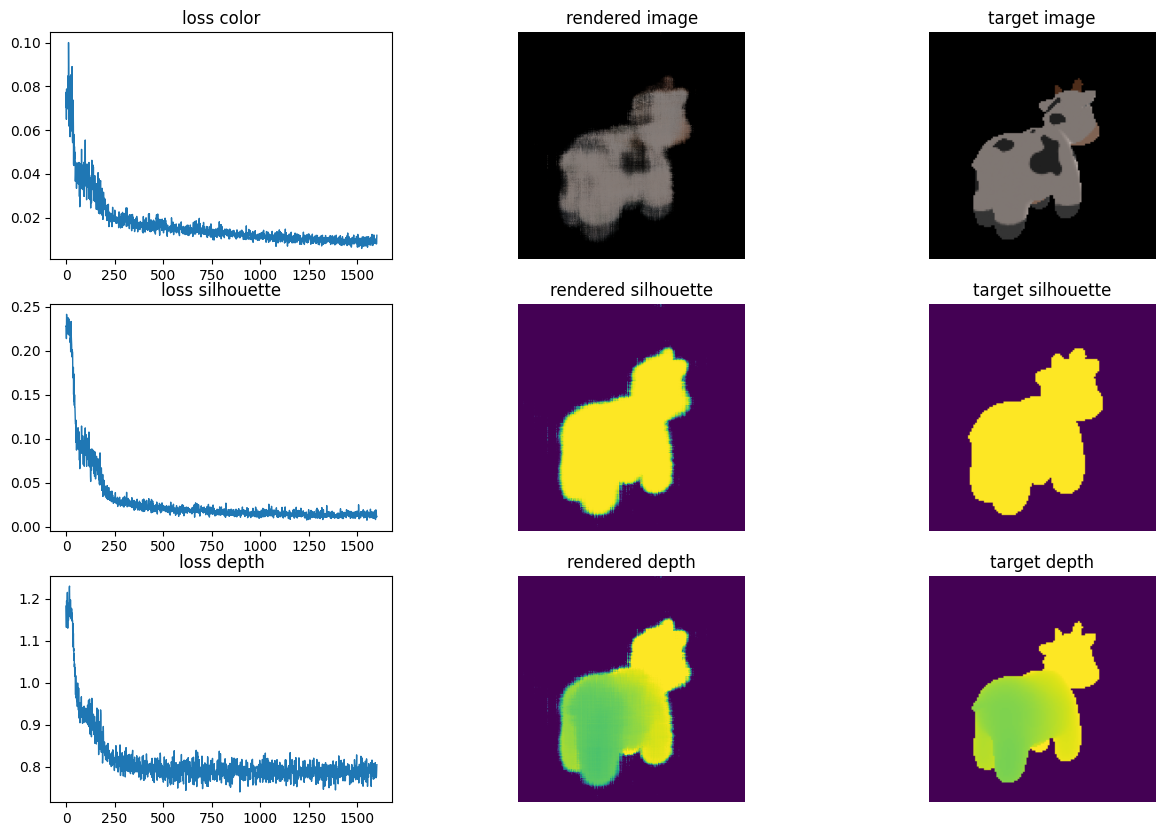

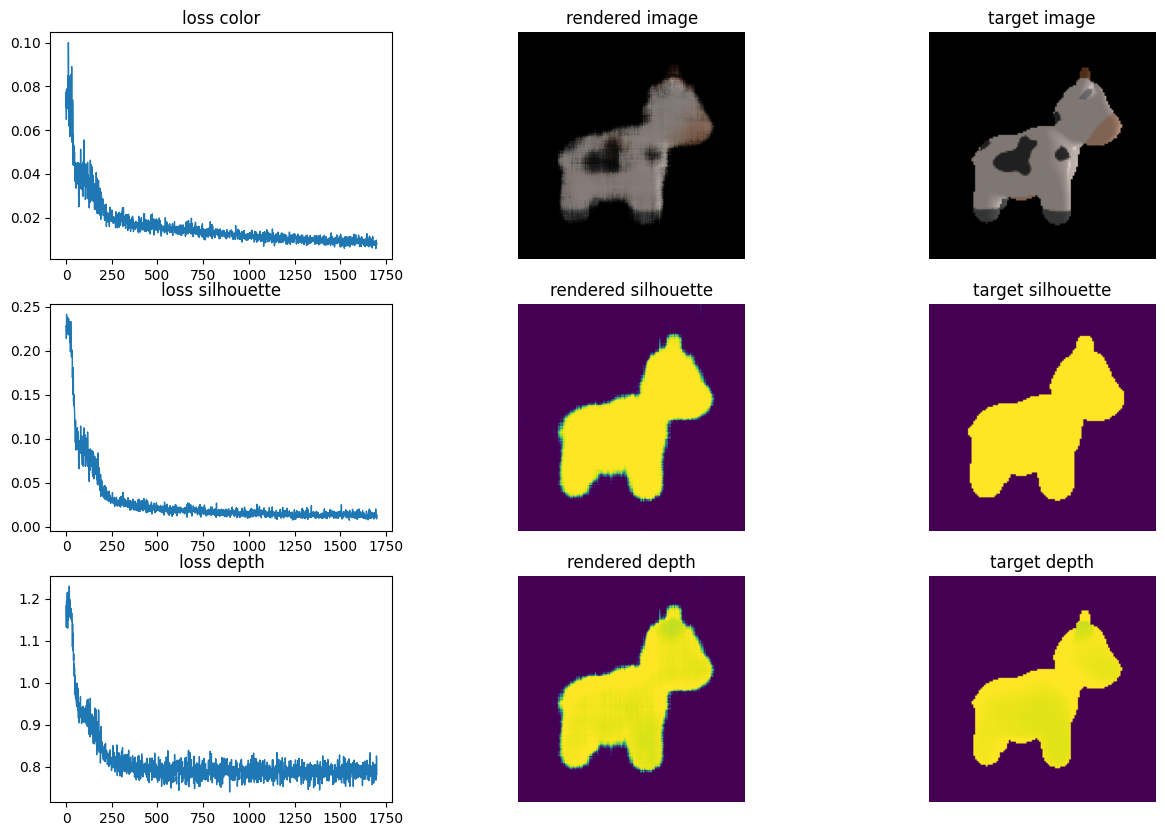

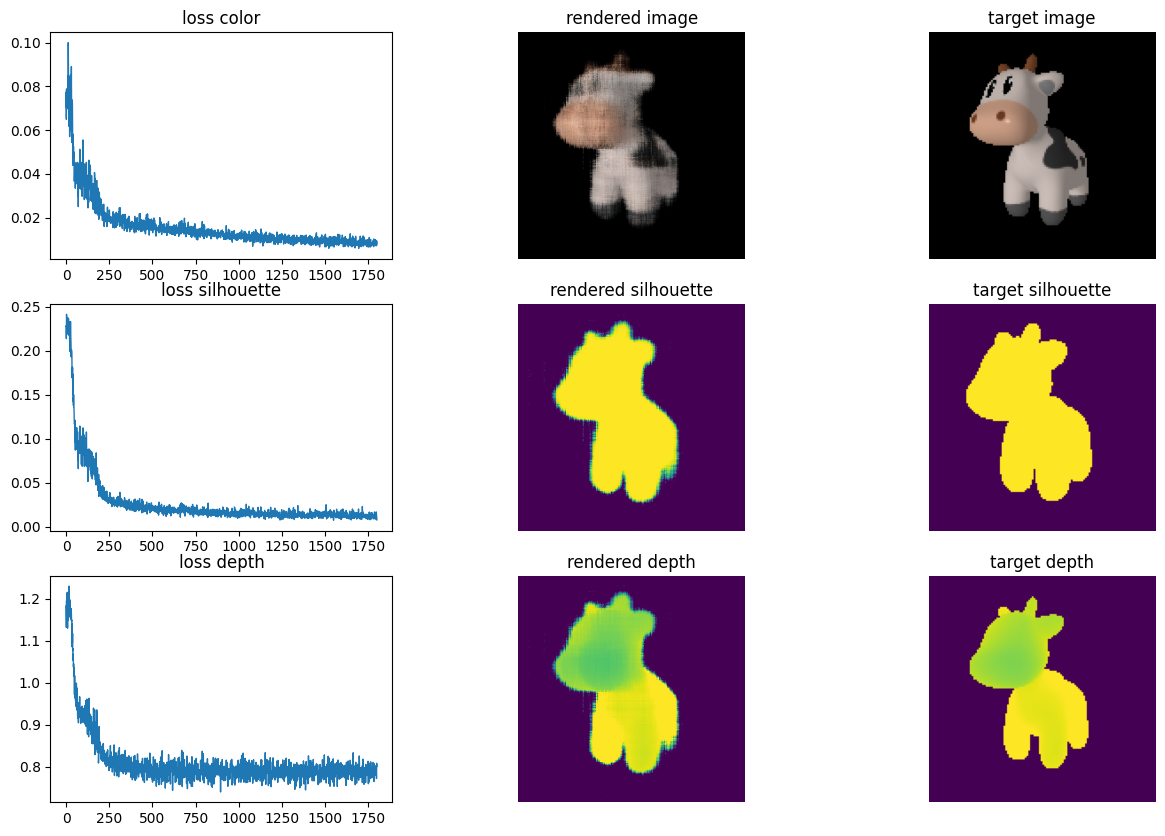

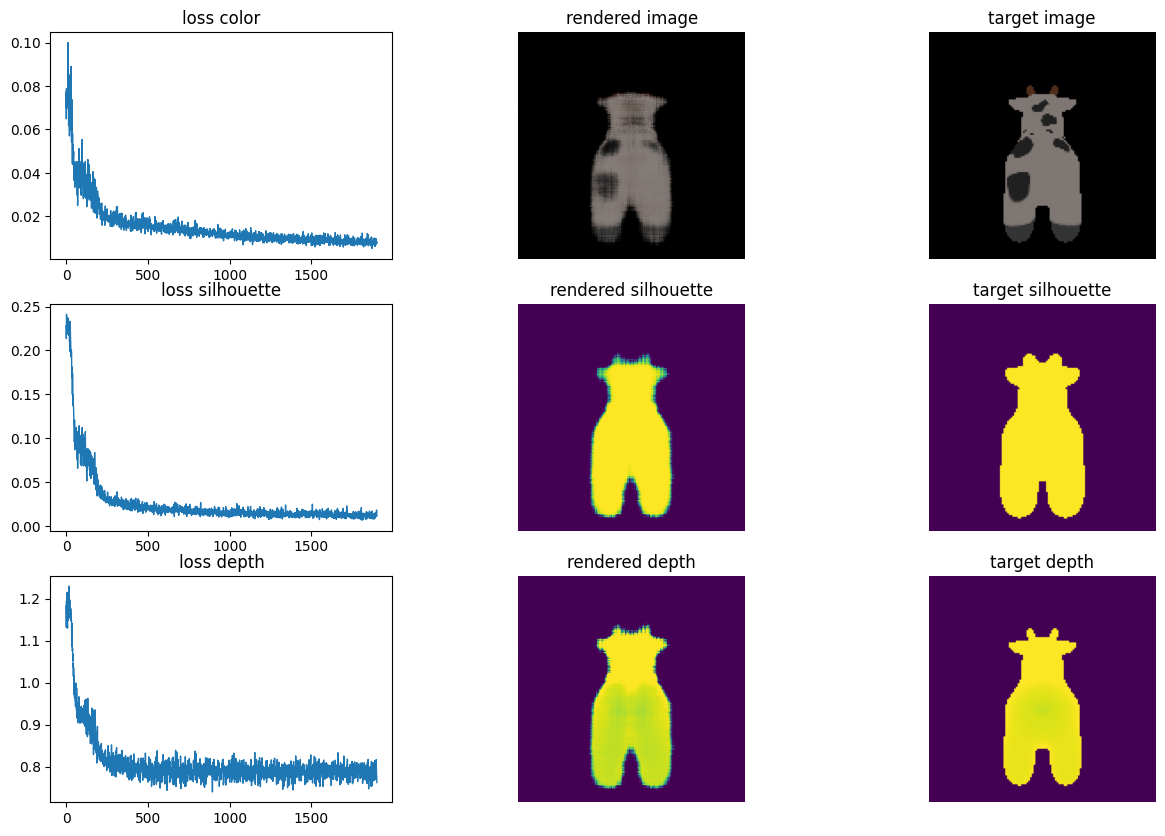

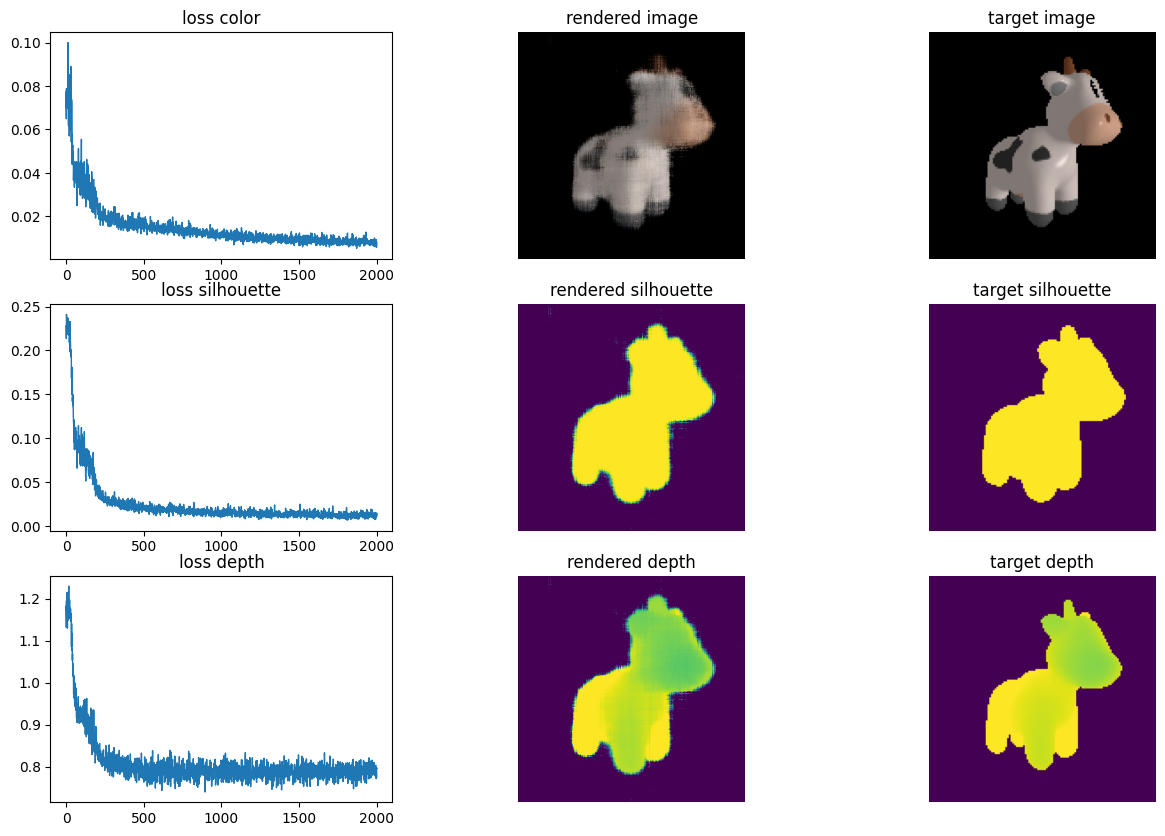

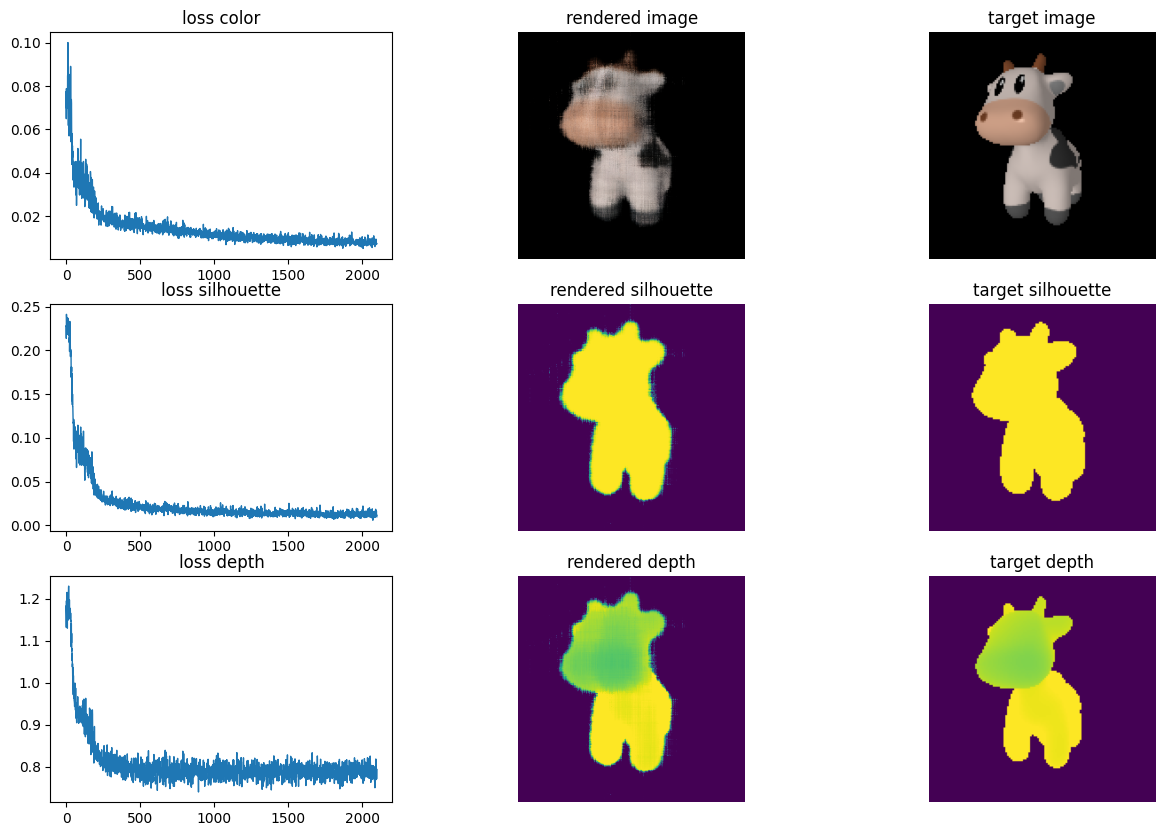

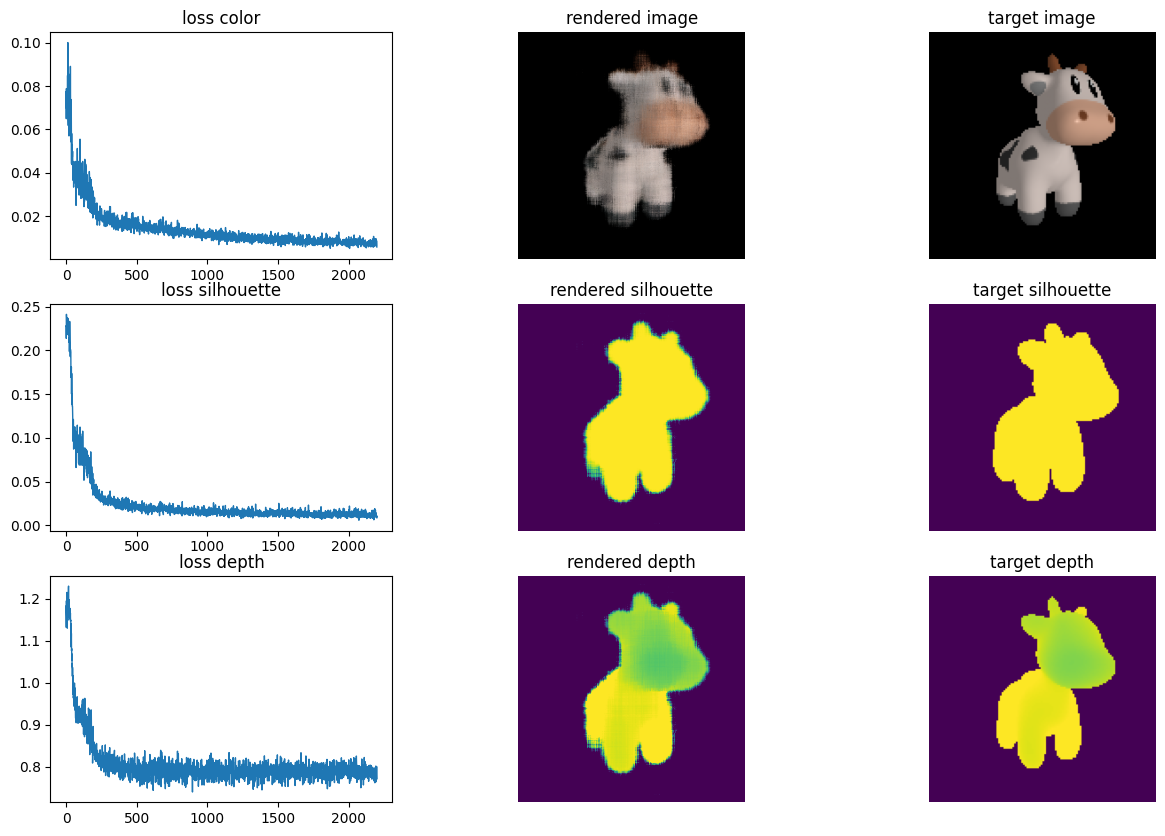

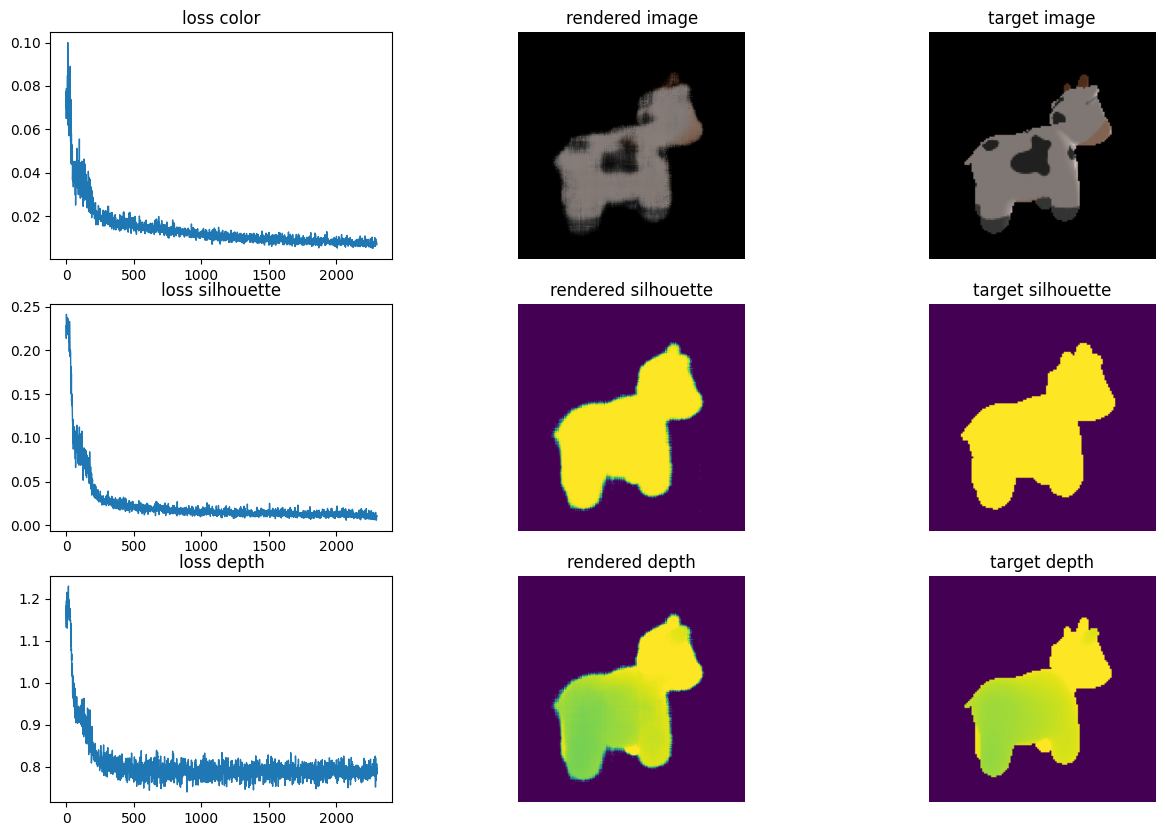

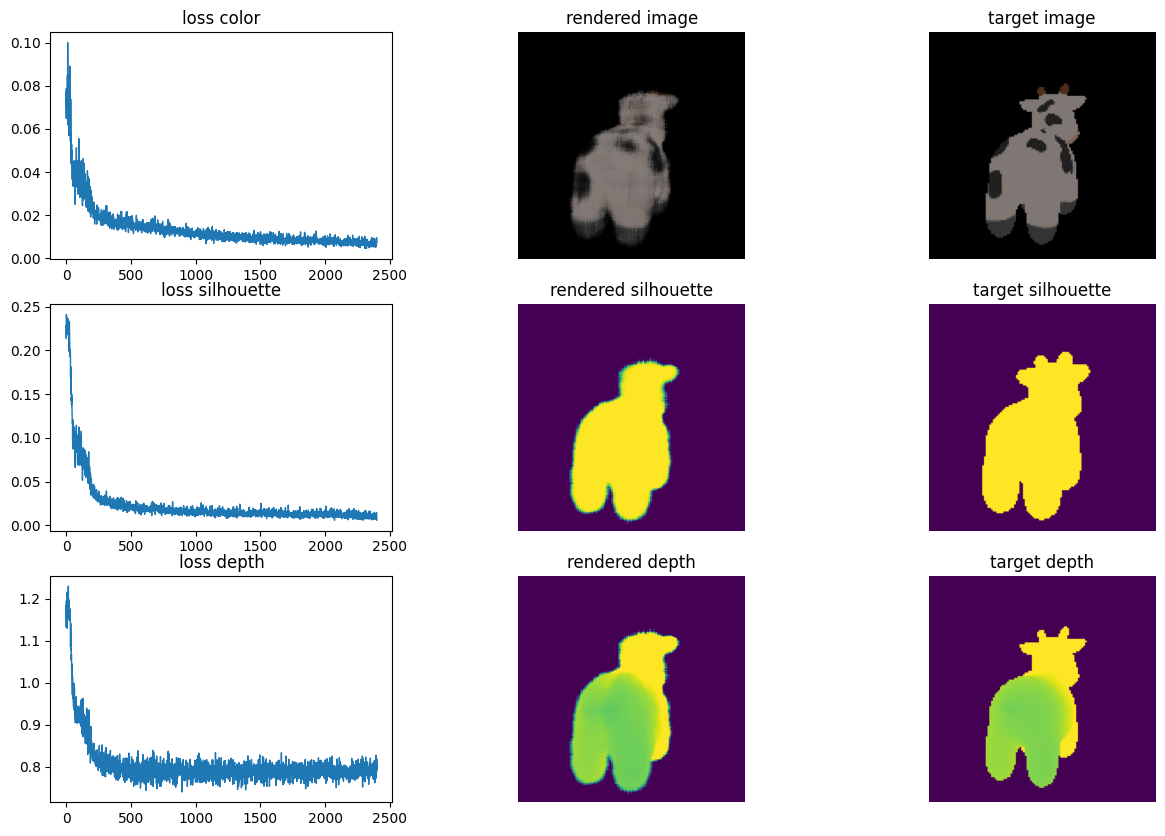

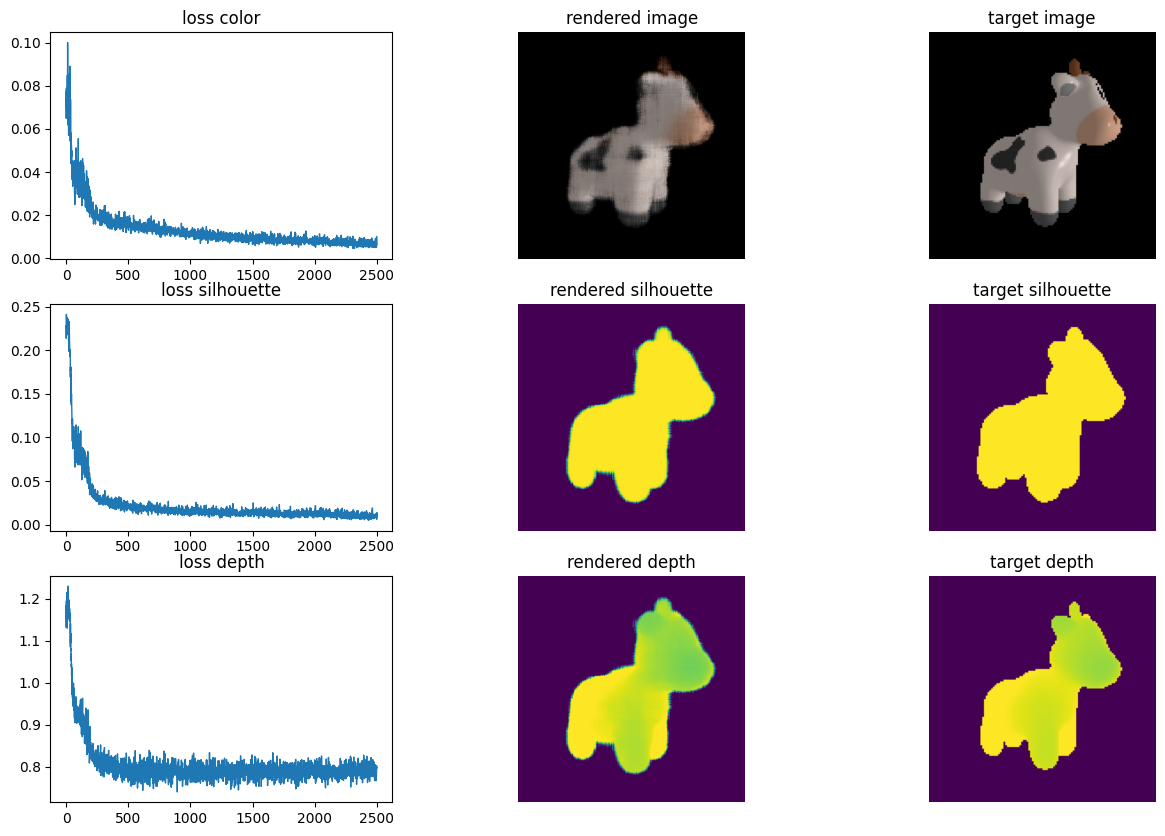

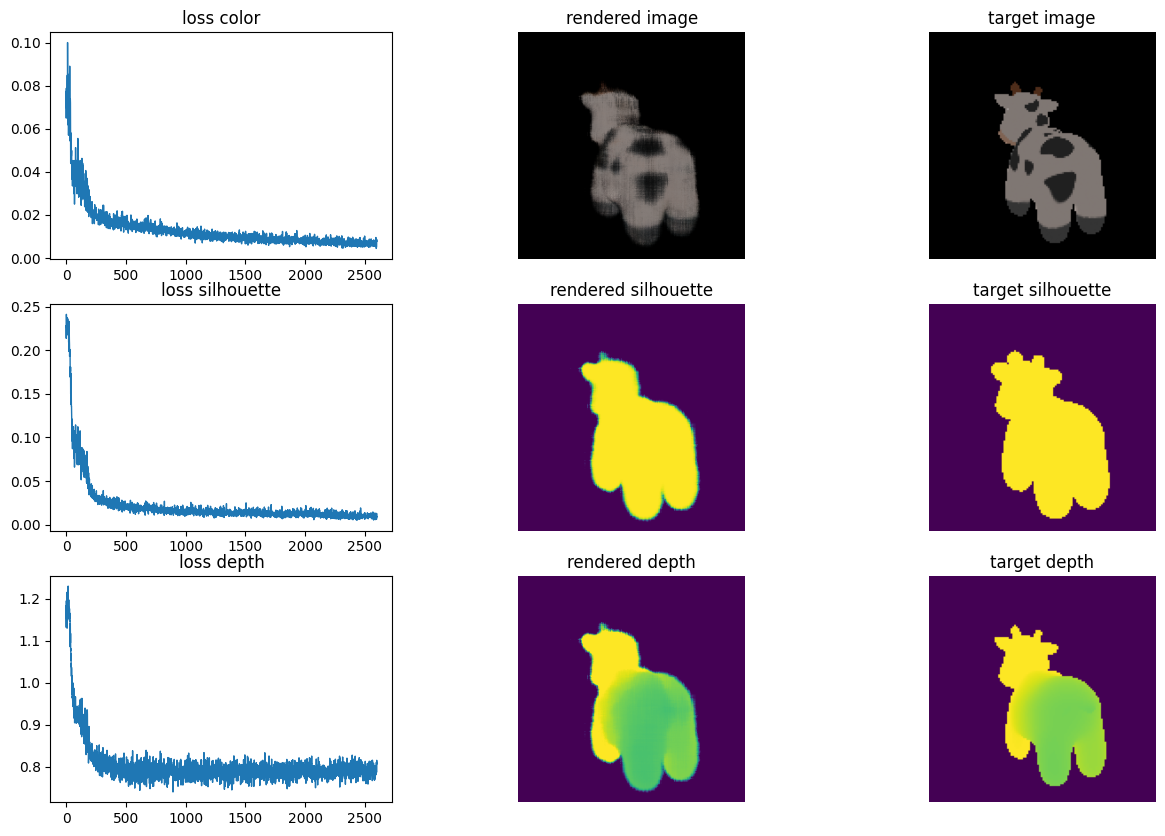

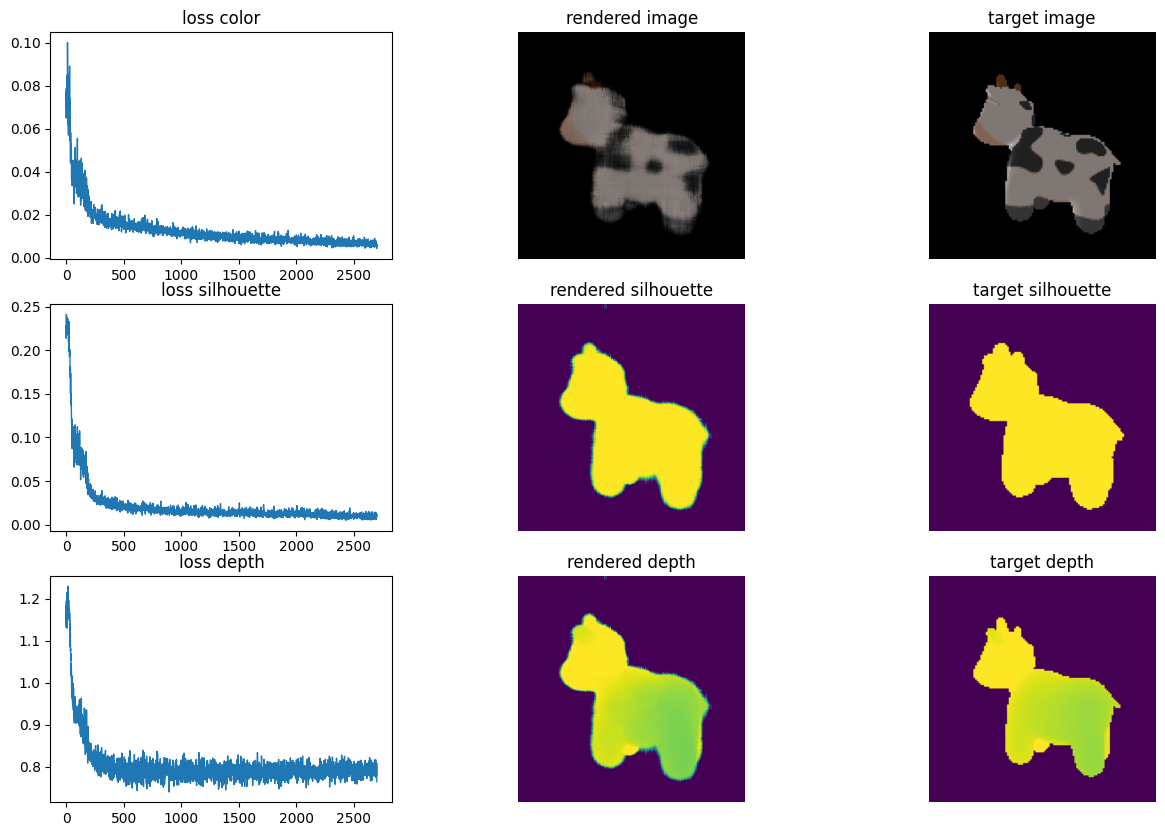

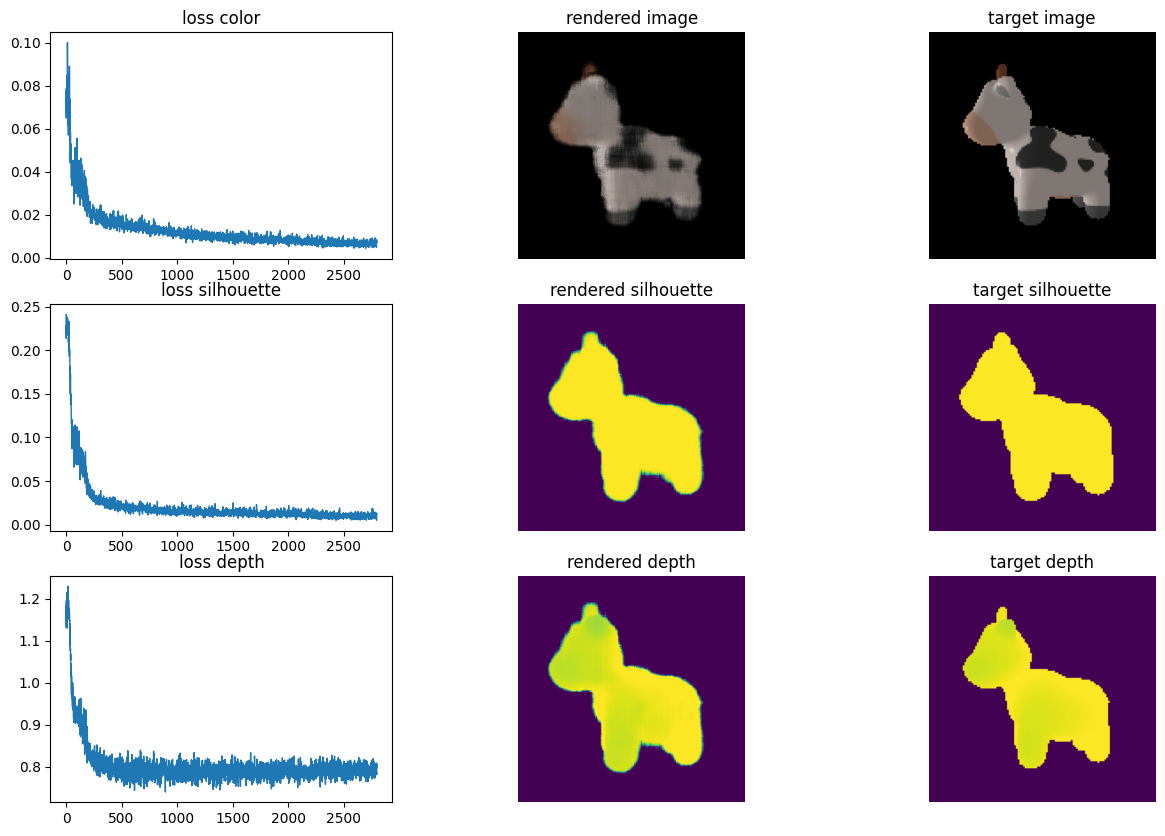

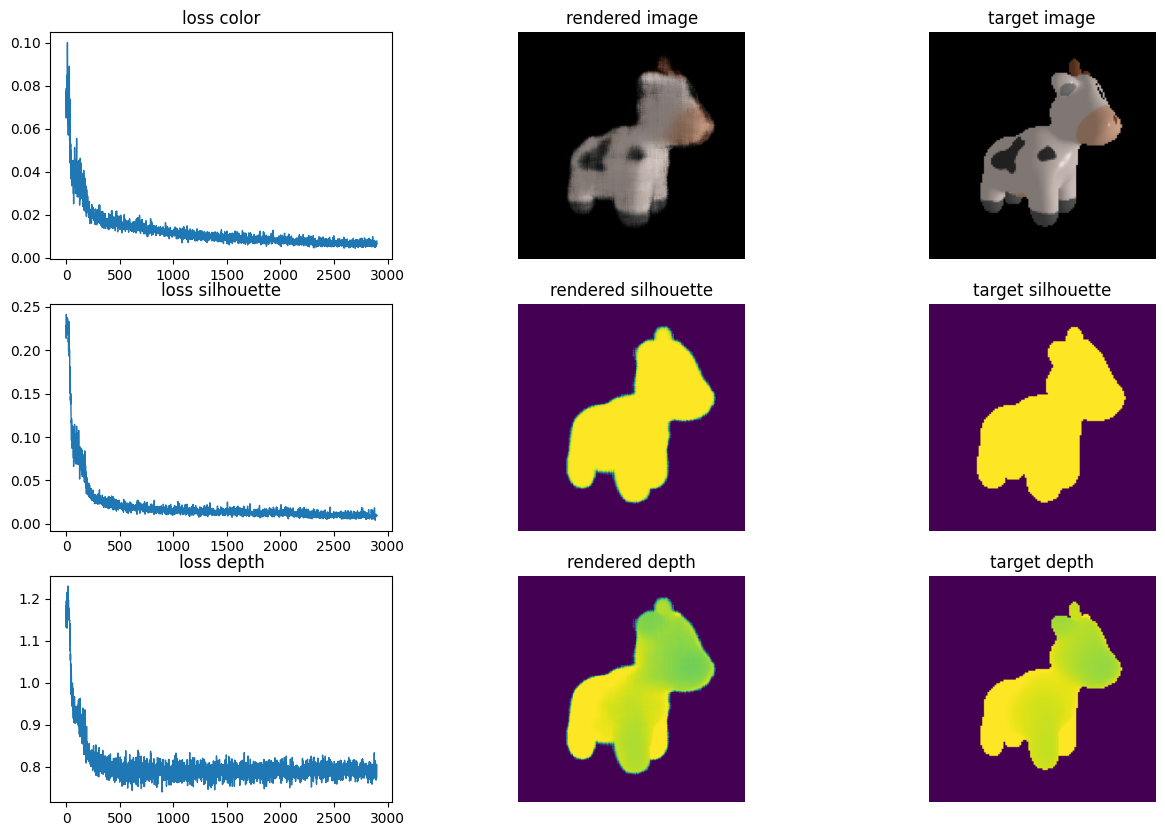

In [12]:
# First move all relevant variables to the correct device.
renderer_grid = renderer_grid.to(device)
renderer_mc = renderer_mc.to(device)
target_cameras = target_cameras.to(device)
target_images = target_images.to(device)
target_silhouettes = target_silhouettes.to(device)
# depth
target_depths = target_depths.to(device)

# Set the seed for reproducibility
torch.manual_seed(1)

# Instantiate the radiance field model.
neural_radiance_field = NeuralRadianceField().to(device)

# Instantiate the Adam optimizer. We set its master learning rate to 1e-3.
lr = 1e-3
optimizer = torch.optim.Adam(neural_radiance_field.parameters(), lr=lr)

# We sample random cameras in a minibatch. Each camera
# emits raysampler_mc.n_pts_per_image rays.
batch_size = 3

# 3000 iterations take ~20 min on a Tesla M40 and lead to
# reasonably sharp results. However, for the best possible
# results, we recommend setting n_iter=20000.
n_iter = 3000

# Init the loss history buffers.
loss_history_color, loss_history_sil, loss_history_depth = [], [], []

# The main optimization loop.
for iteration in range(n_iter):
    # In case we reached the last 75% of iterations,
    # decrease the learning rate of the optimizer 10-fold.
    if iteration == round(n_iter * 0.75):
        print('Decreasing LR 10-fold ...')
        optimizer = torch.optim.Adam(
            neural_radiance_field.parameters(), lr=lr * 0.1
        )

    # Zero the optimizer gradient.
    optimizer.zero_grad()

    # Sample random batch indices.
    batch_idx = torch.randperm(len(target_cameras))[:batch_size]

    # Sample the minibatch of cameras.
    batch_cameras = FoVPerspectiveCameras(
        R = target_cameras.R[batch_idx],
        T = target_cameras.T[batch_idx],
        znear = target_cameras.znear[batch_idx],
        zfar = target_cameras.zfar[batch_idx],
        aspect_ratio = target_cameras.aspect_ratio[batch_idx],
        fov = target_cameras.fov[batch_idx],
        device = device,
    )

    # Evaluate the nerf model.
    rendered_images_silhouettes, sampled_rays = renderer_mc(
        cameras=batch_cameras,
        volumetric_function=nerf_rgb_only
    )
    rendered_images, rendered_silhouettes = (
        rendered_images_silhouettes.split([3, 1], dim=-1)
    )

    # Compute the silhouette error as the mean huber
    # loss between the predicted masks and the
    # sampled target silhouettes.
    silhouettes_at_rays = sample_images_at_mc_locs(
        target_silhouettes[batch_idx, ..., None],
        sampled_rays.xys
    )
    sil_err = huber(
        rendered_silhouettes,
        silhouettes_at_rays,
    ).abs().mean()

    # Compute the color error as the mean huber
    # loss between the rendered colors and the
    # sampled target images.
    colors_at_rays = sample_images_at_mc_locs(
        target_images[batch_idx],
        sampled_rays.xys
    )
    color_err = huber(
        rendered_images,
        colors_at_rays,
    ).abs().mean()

    # TODO: d. Implement Depth Interface and Loss
    # Note: Call neural_radiance_field.forward to obatin the rendered_depths
    _, _, rendered_depths = neural_radiance_field(sampled_rays)

    # Note: use the same sample_images_at_mc_locs fucntion and huber loss
    gt_depth_at_rays = sample_images_at_mc_locs(
        target_depths[batch_idx, ..., None],
        sampled_rays.xys
        )
    depth_err = huber(rendered_depths, gt_depth_at_rays).abs().mean()

    # TODO: e. Depth Loss Weighting Experiment
    # The optimization loss is a simple sum of the color, silhouette, and dpeth errors.
    depth_weight = 0.1
    loss = color_err + sil_err + depth_weight * depth_err

    # Log the loss history.
    loss_history_color.append(float(color_err))
    loss_history_sil.append(float(sil_err))
    loss_history_depth.append(float(depth_err))

    # Every 10 iterations, print the current values of the losses.
    if iteration % 10 == 0:
        print(
            f'Iteration {iteration:05d}:'
            + f' loss color = {float(color_err):1.2e}'
            + f' loss silhouette = {float(sil_err):1.2e}'
            + f' loss depth = {float(depth_err):1.2e}'
        )

    # Take the optimization step.
    loss.backward()
    optimizer.step()

    # Visualize the full renders every 100 iterations.
    if iteration % 100 == 0:
        show_idx = torch.randperm(len(target_cameras))[:1]
        show_full_render(
            neural_radiance_field,
            FoVPerspectiveCameras(
                R = target_cameras.R[show_idx],
                T = target_cameras.T[show_idx],
                znear = target_cameras.znear[show_idx],
                zfar = target_cameras.zfar[show_idx],
                aspect_ratio = target_cameras.aspect_ratio[show_idx],
                fov = target_cameras.fov[show_idx],
                device = device,
            ),
            target_images[show_idx][0],
            target_silhouettes[show_idx][0],
            target_depths[show_idx][0],
            loss_history_color,
            loss_history_sil,
            loss_history_depth
        )

Rendering rotating NeRF ...


  0%|          | 0/15 [00:00<?, ?it/s]

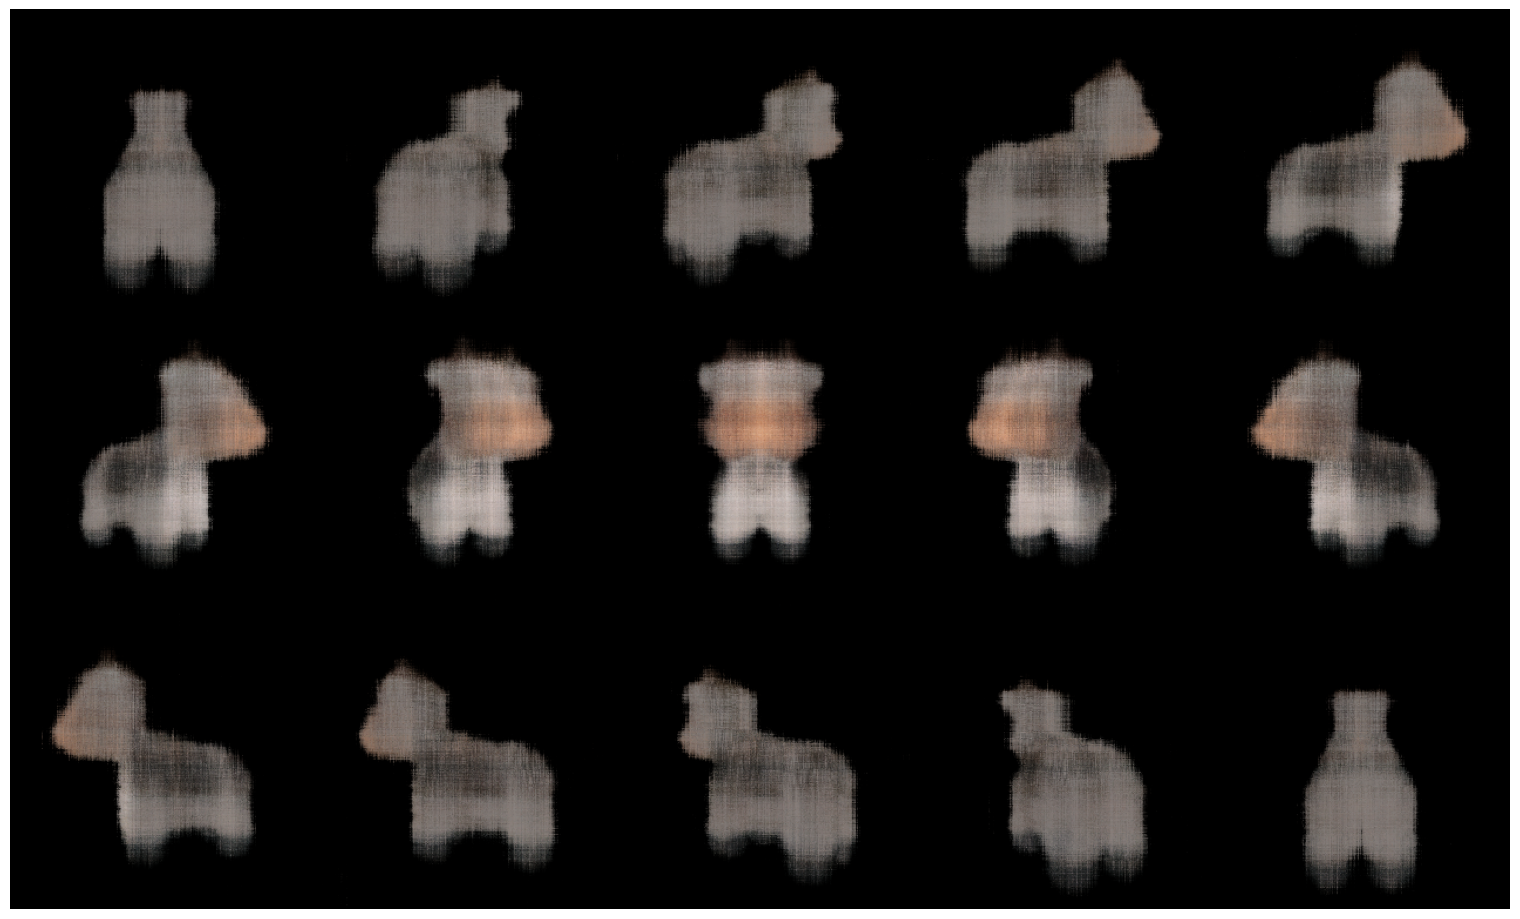

In [11]:
def generate_rotating_nerf(neural_radiance_field, n_frames = 50):
    logRs = torch.zeros(n_frames, 3, device=device)
    logRs[:, 1] = torch.linspace(-3.14, 3.14, n_frames, device=device)
    Rs = so3_exp_map(logRs)
    Ts = torch.zeros(n_frames, 3, device=device)
    Ts[:, 2] = 2.7
    frames = []
    print('Rendering rotating NeRF ...')
    for R, T in zip(tqdm(Rs), Ts):
        camera = FoVPerspectiveCameras(
            R=R[None],
            T=T[None],
            znear=target_cameras.znear[0],
            zfar=target_cameras.zfar[0],
            aspect_ratio=target_cameras.aspect_ratio[0],
            fov=target_cameras.fov[0],
            device=device,
        )
        # Note that we again render with `NDCMultinomialRaysampler`
        # and the batched_forward function of neural_radiance_field.
        frames.append(
            renderer_grid(
                cameras=camera,
                volumetric_function=nerf_rgb_only_batched,
            )[0][..., :3]
        )
    return torch.cat(frames)

with torch.no_grad():
    rotating_nerf_frames = generate_rotating_nerf(neural_radiance_field, n_frames=3*5)

image_grid(rotating_nerf_frames.clamp(0., 1.).cpu().numpy(), rows=3, cols=5, rgb=True, fill=True)
plt.show()

## License

This code is adapted from the PyTorch3D project by Meta Platforms, Inc., which is licensed under the BSD 3-Clause License.

**Original Copyright Notice:**
> Copyright (c) Meta Platforms, Inc. and affiliates. All rights reserved.

Redistribution and use in source and binary forms, with or without modification, are permitted under the terms of the BSD 3-Clause License.

### Educational Use

This version has been modified for use in the Lecture Humanoid Robotics at the University of Bonn.  

The modifications include simplification, reorganization, and adaptation for educational purposes.  
Students are allowed to use and modify this code for **non-commercial, educational use only**.